# ML model in pytorch:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 8.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 30.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 43.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 31.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.1 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516317 sha256=5cadc505a537391f3dce4508b7c8fb56a968bbda199c9e184fba157cb5ba54ac
  Stored in directory: /root/.cache/pip/whee

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:Tesla P100-PCIE-16GB


### Helper scripts:

In [4]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *

# Import custom scripts
#sys.path.append('../')
#from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [5]:
"""
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt"""

"\nauth.authenticate_user()\n# Give our project ID\nproject_id = 'ee-iceshelf-gee4geo'\n!gcloud config set project {project_id}\n# Download the file from a given Google Cloud Storage bucket.\n!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt\n# Print the result to make sure the transfer worked.\n!cat /tmp/gsutil_download.txt"

### Set up Google Drive:

In [6]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive/My\ Drive/Master-thesis/saved_models/

 MODEL_2022-05-11_Larsen_100_32_Baseline.pth
 MODEL_2022-05-16_Larsen_100_32_Baseline_MSE.pth
 MODEL_2022-05-16_Larsen_100_32_Baseline_NRMSE.pth
 MODEL_2022-05-16_Larsen_100_32_Baseline_RMSE.pth
 MODEL_2022-05-17_Larsen_100_32_Attention_MSE.pth
 MODEL_2022-05-17_Larsen_100_32_Attention_NRMSE.pth
 MODEL_2022-05-17_Larsen_100_32_Attention_RMSE.pth
 MODEL_2022-05-19_Larsen_100_32_Attention_NRMSE.pth
 MODEL_2022-05-20_Larsen_11_32_Baseline_MSE.pth
 MODEL_2022-05-20_Larsen_15_32_Attention_MSE.pth
 MODEL_2022-05-20_Larsen_17_32_Attention_MSE.pth
 MODEL_2022-05-20_Larsen_21_32_Attention_NRMSE.pth
 MODEL_2022-05-20_Larsen_22_32_Attention_NRMSE.pth
 MODEL_2022-05-20_Larsen_23_32_Attention_MSE.pth
 MODEL_2022-05-20_Larsen_23_32_Attention_NRMSE.pth
 MODEL_2022-05-20_Larsen_23_32_Baseline_NRMSE.pth
 MODEL_2022-05-20_Larsen_24_32_Baseline_NRMSE.pth
 MODEL_2022-05-20_Larsen_26_32_Baseline_MSE.pth
 MODEL_2022-05-20_Larsen_30_32_Attention_MSE.pth
 MODEL_2022-05-20_Larsen_30_32_Attention_NRMSE.pth
 MOD

## Load data:

### (Input) Global climate model:

In [64]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    idGCMLike = '1ab88hzzd5D9RIDsI6LdGAKO6DFo_R3L2'
    downloaded = Googledrive.CreateFile({'id':idGCMLike}) 
    downloaded.GetContentFile(fileGCMLike)  
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
print(GCMLike.dims)
GCMLike['EW'].attrs['long_name'] = 'Eastward Near-Surface Wind'
GCMLike

INFO: access_token is expired. Now: 2022-06-07 09:09:16.615460, token_expiry: 2022-06-07 08:51:57.368051


Frozen({'x': 90, 'y': 25, 'time': 1452})


<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
    PR           (time, y, x) float32 ...
    NW           (time, y, x) float64 ...
    EW           (time, y, x) float64 ...
Attributes:
    crs:      3031

In [65]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<string>:6: ShapelyDeprecationWarning: The array interface is deprecated 

### (Target) Regional climate model:

In [66]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    #idTarget = '15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI'
    idTarget = '1r8mVOIo6GDTe6fHb9EZikZMdwPHurHSe'
    downloaded = Googledrive.CreateFile({'id':idTarget}) 
    downloaded.GetContentFile(fileTarget) 
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen({'time': 1452, 'x': 176, 'y': 148})
New target dimensions: Frozen({'time': 1452, 'y': 148, 'x': 160})
CPU times: user 2.13 s, sys: 310 ms, total: 2.44 s
Wall time: 5.85 s


In [67]:
target_dataset

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Data variables:
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

### Real GCM:

In [68]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCM)
    GCMLike = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
else:
    idGCM = '1pVEneiRX1mievDwUcEXQ9ukWyU6exAyM'
    downloaded = Googledrive.CreateFile({'id':idGCM}) 
    downloaded.GetContentFile(fileGCM)  
    GCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
GCM = GCM.rename_vars({'ps':'SP', 'uas':'EW', 'vas':'NW', 'pr':'PR', 
                       'tas': 'TT', 
                       'rsds':'SWD', 'rlds':'LWD', 'huss':'QQP', 'hurs':'RH'})

CPU times: user 1.96 s, sys: 287 ms, total: 2.24 s
Wall time: 7.68 s


In [69]:
GCM

<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
    spatial_ref  int64 ...
Data variables:
    QQP          (time, y, x) float32 ...
    RH           (time, y, x) float32 ...
    PR           (time, y, x) float64 ...
    TT           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    NW           (time, y, x) float32 ...
    EW           (time, y, x) float32 ...
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0
    crs:                    3031

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


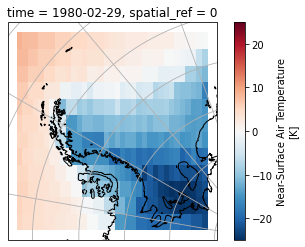

In [70]:
ds = createLowerInput(GCM, region='Larsen', Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)
ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo() )
ds.TT.isel(time = 1).plot(x='x', ax = ax, transform=ccrs.SouthPolarStereo())
ax.coastlines("10m", color="black")
ax.gridlines()

In [71]:
sorted(list(GCMLike.data_vars))

['EW', 'LWD', 'NW', 'PR', 'QQP', 'RF', 'SF', 'SMB', 'SP', 'SWD', 'TT', 'TTP']

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

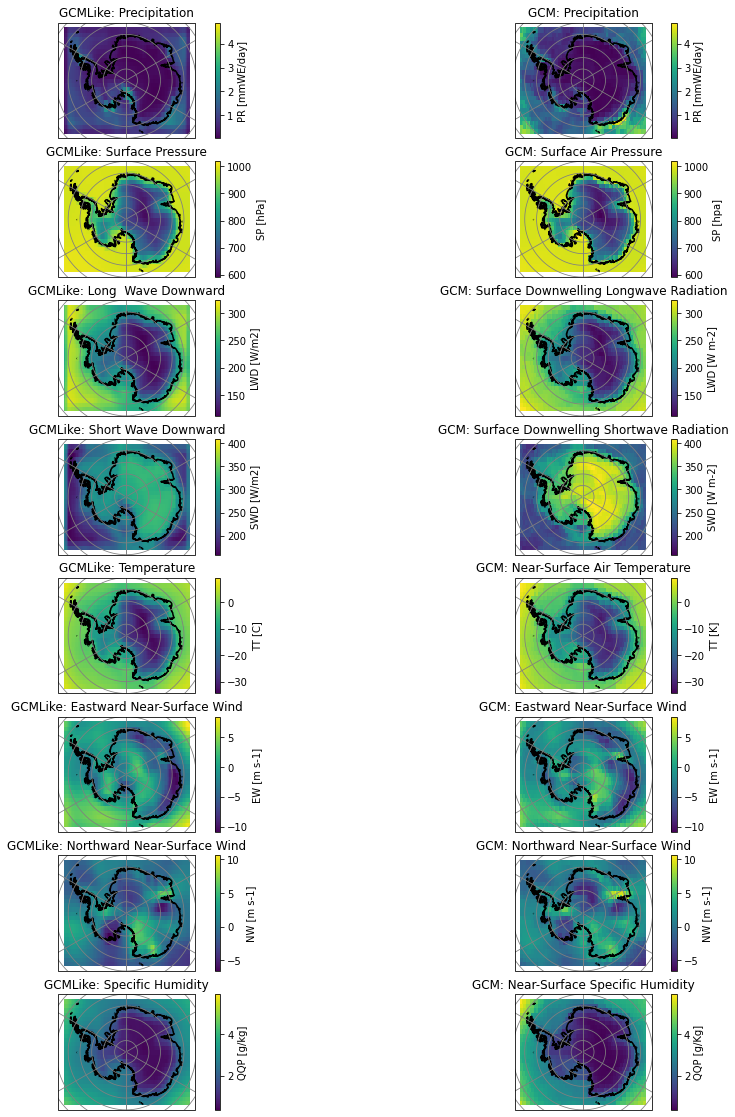

In [72]:
vars =['PR', 'SP', 'LWD','SWD','TT', 'EW', 'NW', 'QQP']
plotAllVar2Xr(
    GCMLike.drop(['SMB']),  # xr.Dataset
    GCM,
    m = 8,
    n = 2,
    vars_ = vars
)

## Input and target for model:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

For pytorch need to put into `[nbmonths, nb_vars, x, y]`

### Input:

In [73]:
# variables in GCMLike
all_vars_RCM = sorted(list(GCMLike.data_vars))
print(all_vars_RCM)

# variables we want to train on:
vars =['PR', 'SP', 'LWD','SWD','TT', 'UUP', 'VVP', 'QQP']

# difference between both
def Diff(li1, li2):
  return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
 
print('Variables to drop:', Diff(all_vars_RCM, vars))

['EW', 'LWD', 'NW', 'PR', 'QQP', 'RF', 'SF', 'SMB', 'SP', 'SWD', 'TT', 'TTP']
Variables to drop: ['SMB', 'RF', 'EW', 'NW', 'SF', 'TTP', 'VVP', 'UUP']


In [74]:
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
        GCMLike = GCMLike, 
        GCM = None, 
        size_input_domain = SIZE_INPUT_DOMAIN, 
        Region=REGION, 
        dropvarGCM = None, 
        dropvarRCM = ['RF', 'SF', 'TTP'])

inputs_2D_ns = [i2D_ns]
inputs_1D_ns = [i1D_ns]
inputs_2D = [i2D]
inputs_1D = [i1D]
REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike


### Target:

In [75]:
if REGION == "Combined":
    targets, target_times = [], []
    for r in REGIONS:
        t, t_times = target_maker(target_dataset, region=r, resize=False)
        targets.append(t[0])
        target_times.append(t_times[0])
else:
    targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 8)
Input 1D: (1452, 1, 1, 18)


### Example of each region of Antarctica:
Plot an example of each region that is used.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


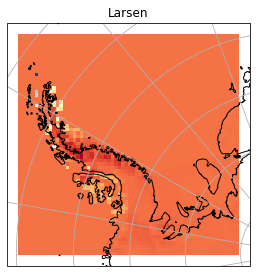

In [34]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

### Examples of input to model:
Show an example of process of how dataset is

2D Feature batch shape: torch.Size([32, 8, 32, 32])
1D Feature batch shape: torch.Size([32, 18, 1, 1])
Labels batch shape: torch.Size([32, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

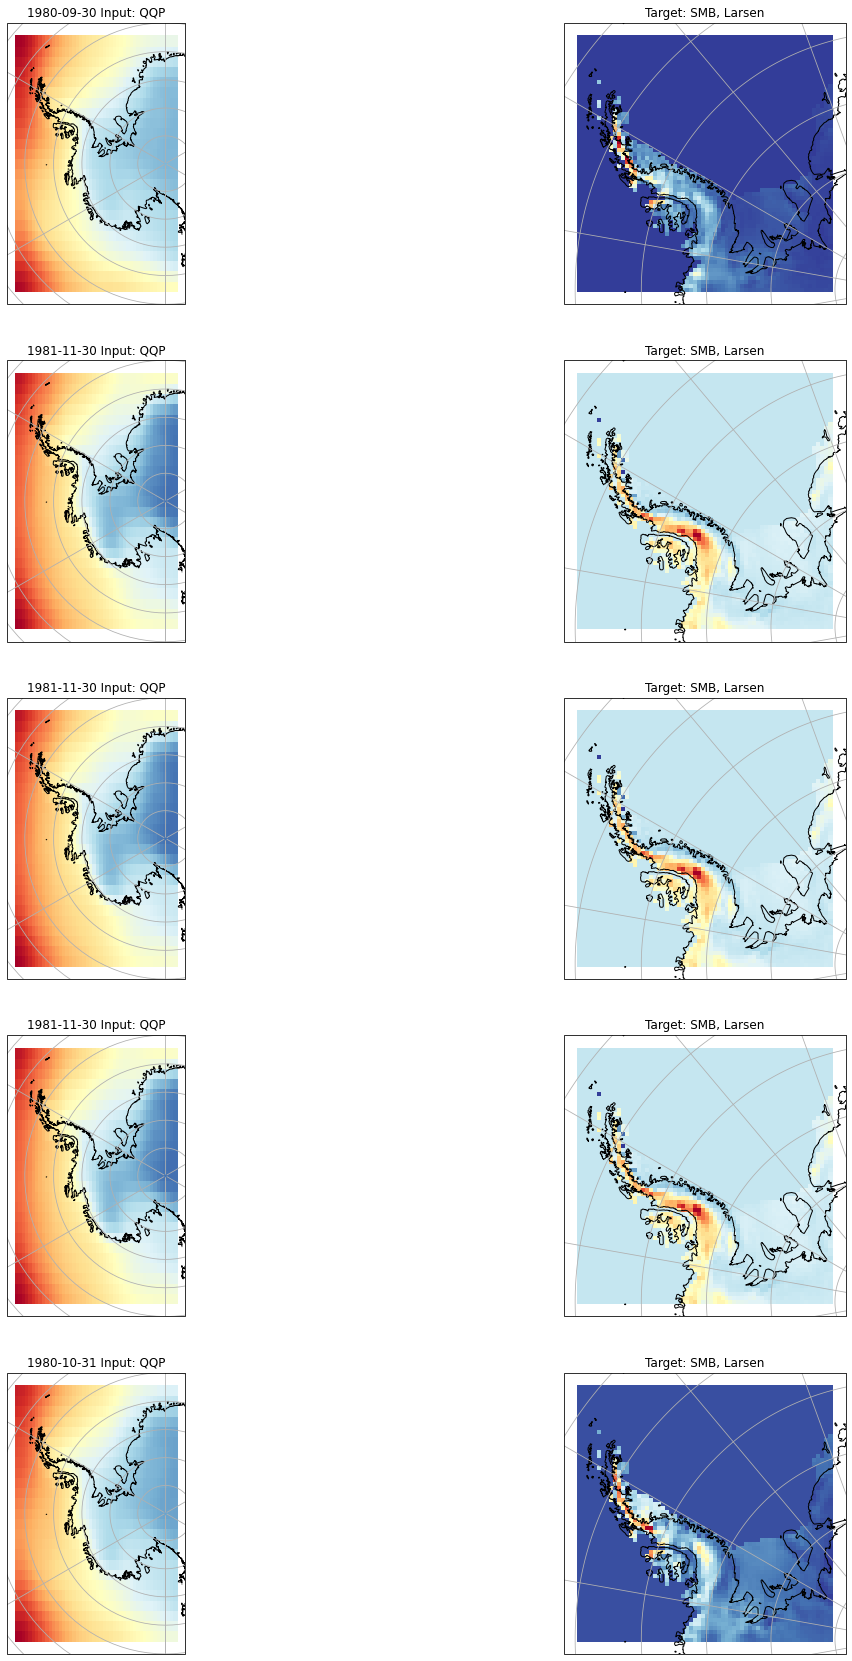

In [35]:
#  Create pytorch tensors:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
R = regionEncoder(X, REGION) # region encoder
X.shape, Z.shape, Y.shape, len(R)

# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)

# 4. Display input and targets.
N = 5 
f = plt.figure(figsize=(20, 30))

for i in range(N):
  train_X, train_Z, train_Y, train_R = next(iter(loader))
  randTime = rn.randint(0, len(train_X)-1)
  sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
  sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
  sampleregion = train_R[randTime]
  dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
  time = str(dt.date[0])

  if REGION != "Whole Antarctica":
      sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
  else:
      sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)
  vmin = np.min(sampletarget_)
  vmax = np.max(sampletarget_)

  M = 2
  for m in range(M):
    if m == 0:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTrain(GCMLike, sample2dtrain_, 4, ax, time, VAR_LIST, region=REGIONS[sampleregion])
    if m == 1:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=REGIONS[sampleregion])

## U-Net:

In [36]:
from unet import *
from SmaAt_UNet import *

In [37]:
from dataFunctions import *
from makeInputs import *
from config import *

In [38]:
from training import *
from prediction import *
from metrics import *

In [39]:
SEED

0

## Training

In [40]:
from dataFunctions import *
from makeInputs import *
from config import *
from training import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Larsen, Baseline - MSE:

In [41]:
# variables in GCMLike
all_vars_RCM = sorted(list(GCMLike.data_vars))
all_vars_GCM = sorted(list(GCM.data_vars))

# variables we want to train on:
vars =['PR', 'SP', 'LWD','SWD','TT', 'UUP', 'VVP', 'QQP']

print('Variables in GCMLike:',all_vars_RCM)
print('Variables in GCM:', sorted(list(GCM.data_vars)))
print('Variables to drop in GCMLike:', Diff(all_vars_RCM, vars))
print('Variables to drop in GCM:', Diff(all_vars_GCM, vars))

Variables in GCMLike: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'RF', 'SF', 'SMB', 'SP', 'SWD', 'TT', 'TTP']
Variables in GCM: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'RH', 'SP', 'SWD', 'TT']
Variables to drop in GCMLike: ['SMB', 'RF', 'EW', 'NW', 'SF', 'TTP', 'VVP', 'UUP']
Variables to drop in GCM: ['NW', 'RH', 'EW', 'VVP', 'UUP']


Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 8)
Input 1D: (1452, 1, 1, 18)


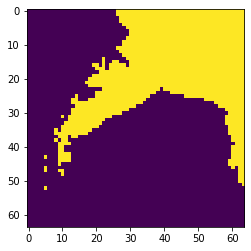

In [76]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    GCM = None,
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    dropvarGCM = None, dropvarRCM = ['RF', 'SF', 'TTP']
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

In [43]:
%%time
seed_all(SEED)
NUM_EPOCHS = 40
LOSS_ = 'MSE'
TYPENET = 'Baseline'
LR = 0.005
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 15,
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
    full_input,
    full_target,
    torch.tensor(mask),
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Baseline model


{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'MSE', 'typeNet': 'Baseline', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15}


INFO: Network:
	8 input channels X
	18 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 8, 32, 32])


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.45timestep/s, loss (batch)=1.08]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.35timestep/s, loss (batch)=0.962]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.19timestep/s, loss (batch)=0.879]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.45timestep/s, loss (batch)=0.822]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.79timestep/s, loss (batch)=0.7]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.74timestep/s, loss (batch)=0.519]
INFO: Checkpoint 8 saved!
Epoch 10/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.00timestep/s, loss (batch)=0.444]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.74timestep/s, loss (batch)=0.371]
INFO: Checkpoint 19 saved!
Epoch 26/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.53timestep/s, loss (batch)=0.35]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 31/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.19timestep/s, loss (batch)=0.327]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-06.


Epoch 34/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.47timestep/s, loss (batch)=0.326]
INFO: Stopping early --> mean val score 0.5337180495262146 has not decreased over 15 epochs compared to best 0.5328924655914307 
INFO: Saving model on google drive


CPU times: user 5min 58s, sys: 2min 18s, total: 8min 16s
Wall time: 8min 8s


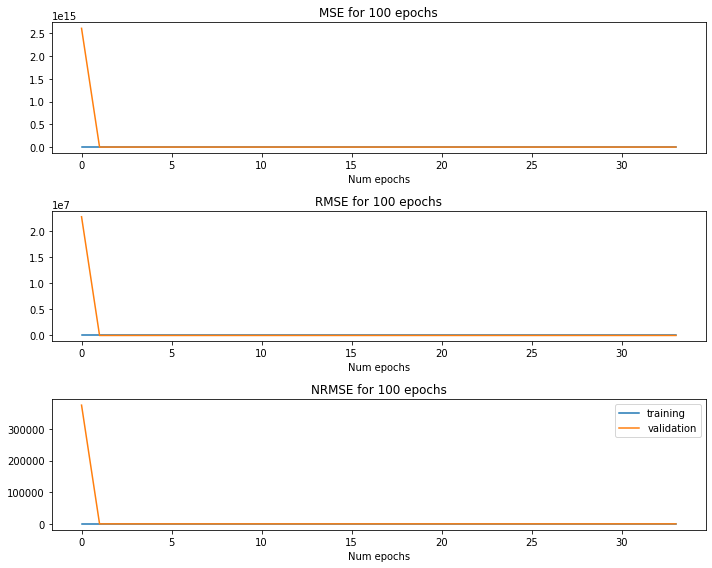

In [44]:
plotLoss(train_loss_e, val_loss_e)

## Larsen, Attention - NRMSE:

In [45]:
from dataFunctions import *
from makeInputs import *
from config import *
from training import *
from prediction import *
from metrics import *
from reproducibility import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
SEED

0

Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 8)
Input 1D: (1452, 1, 1, 18)


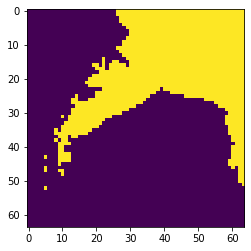

In [77]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike = GCMLike, 
    GCM = None,
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    dropvarGCM = None, dropvarRCM = ['RF', 'SF', 'TTP']
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

In [48]:
%%time
NUM_EPOCHS = 50
LOSS_ = 'NRMSE'
TYPENET = 'Attention'
LR = 0.005
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 15,
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
    full_input,
    full_target,
    torch.tensor(mask),
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 50, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15}


INFO: Network:
	8 input channels X
	18 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 8, 32, 32])


INFO: Starting training:
		Epochs:          50
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/50: 100%|██████████| 1046/1046 [00:11<00:00, 93.10timestep/s, loss (batch)=0.0151]
INFO: Checkpoint 2 saved!
Epoch 3/50: 100%|██████████| 1046/1046 [00:11<00:00, 91.61timestep/s, loss (batch)=0.0139] 
INFO: Checkpoint 3 saved!
Epoch 6/50: 100%|██████████| 1046/1046 [00:11<00:00, 91.86timestep/s, loss (batch)=0.0127] 
INFO: Checkpoint 6 saved!
Epoch 7/50: 100%|██████████| 1046/1046 [00:11<00:00, 91.83timestep/s, loss (batch)=0.0125] 
INFO: Checkpoint 7 saved!
Epoch 17/50: 100%|██████████| 1046/1046 [00:11<00:00, 92.00timestep/s, loss (batch)=0.0115] 


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/50: 100%|██████████| 1046/1046 [00:11<00:00, 90.99timestep/s, loss (batch)=0.0113] 
INFO: Checkpoint 18 saved!
Epoch 24/50: 100%|██████████| 1046/1046 [00:11<00:00, 91.43timestep/s, loss (batch)=0.00964] 


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/50: 100%|██████████| 1046/1046 [00:11<00:00, 92.08timestep/s, loss (batch)=0.00918] 


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/50: 100%|██████████| 1046/1046 [00:11<00:00, 92.11timestep/s, loss (batch)=0.00916] 
INFO: Stopping early --> mean val score 0.014770515263080597 has not decreased over 15 epochs compared to best 0.01489980984479189 
INFO: Saving model on google drive


CPU times: user 4min 29s, sys: 2min 7s, total: 6min 36s
Wall time: 6min 33s


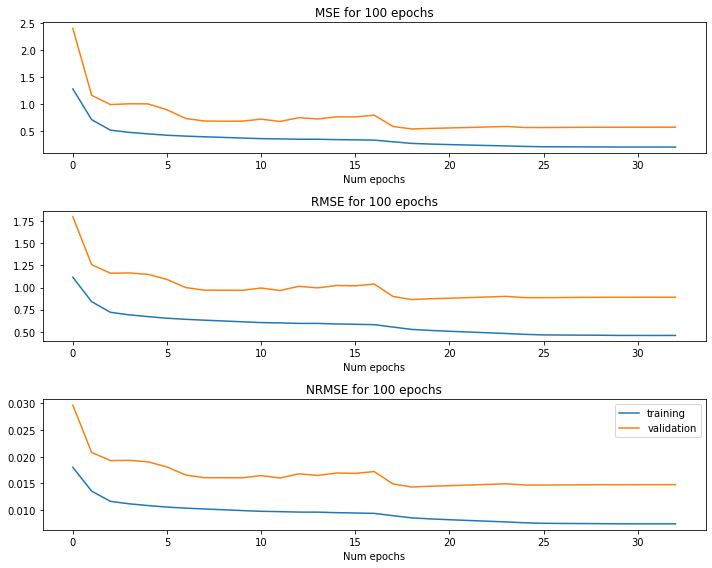

In [49]:
plotLoss(train_loss_e, val_loss_e)

## Feature selection:

Variables used for training: ['LWD', 'PR', 'QQP', 'SP', 'SWD', 'TT', 'UUP', 'VVP']

In [78]:
import itertools
variables = ['LWD', 'PR', 'QQP', 'SP', 'SWD', 'TT', 'EW', 'NW']
list_comb = []
for i in range(1, 5):
    combinations = itertools.combinations(variables, i)
    for comb in combinations:
        # keep only those that remove both winds or none, same for radiation
        if 'EW' in comb and 'NW' in comb:
          if ('LWD' not in comb) and ('SWD' not in comb):
            list_comb.append([el for el in comb])
            continue
        if 'LWD' in comb and 'SWD' in comb:
          if ('EW' not in comb) and ('NW' not in comb):
            list_comb.append([el for el in comb])
          continue
        elif ('LWD' not in comb) and ('EW' not in comb) and ('SWD' not in comb) and ('NW' not in comb):
          list_comb.append([el for el in comb])
          continue
len(list_comb)

37

In [79]:
# drop those anyway
GCMLike = GCMLike.drop(['RF', 'SF', 'TTP'])

In [80]:
metrics_per_params,loss_per_params = [], []

numiter = 1
N = len(list_comb)
#for var in list_comb[:int(N/2)]:
for var in list_comb:
  print(f'Number of iteration:{numiter}/{len(list_comb)}')
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = LR # 0.005
  NUM_EPOCHS = 40

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      dropvarRCM = var, dropvarGCM = None
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  full_input_ns = [
      np.concatenate([i2D_ns], axis=0),
      np.concatenate([i1D_ns], axis=0),
  ]

  REGIONS = [REGION]

  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 15,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_set, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)
  numiter += 1

Number of iteration:1/37
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:12<00:00, 82.28timestep/s, loss (batch)=0.0158]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.94timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:12<00:00, 82.39timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.03timestep/s, loss (batch)=0.013]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.86timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 8 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.17timestep/s, loss (batch)=0.0119] 


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.21timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:12<00:00, 82.16timestep/s, loss (batch)=0.01]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.35timestep/s, loss (batch)=0.00966]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:12<00:00, 82.13timestep/s, loss (batch)=0.00959]
INFO: Stopping early --> mean val score 0.015012969262897968 has not decreased over 15 epochs compared to best 0.014576242305338383 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/content/metrics.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  predictions = torch.tensor(preds).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None,

Number of iteration:2/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.75timestep/s, loss (batch)=0.0166]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.95timestep/s, loss (batch)=0.0143]
INFO: Checkpoint 3 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:12<00:00, 82.28timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:12<00:00, 80.94timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 12/40: 100%|██████████| 1046/1046 [00:12<00:00, 80.77timestep/s, loss (batch)=0.0117]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.30timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 13 saved!
Epoch 19/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.26timestep/s, loss (batch)=0.0101]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.94timestep/s, loss (batch)=0.00948]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-06.


Epoch 28/40: 100%|██████████| 1046/1046 [00:12<00:00, 80.64timestep/s, loss (batch)=0.00942]
INFO: Stopping early --> mean val score 0.014670606702566147 has not decreased over 15 epochs compared to best 0.01448206789791584 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:3/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:13<00:00, 80.40timestep/s, loss (batch)=0.0157]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:12<00:00, 81.40timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.90timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 6 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.96timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 9 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.61timestep/s, loss (batch)=0.0117]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:13<00:00, 80.46timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:12<00:00, 80.51timestep/s, loss (batch)=0.00964]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:13<00:00, 80.40timestep/s, loss (batch)=0.00905]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:13<00:00, 80.00timestep/s, loss (batch)=0.00901]
INFO: Stopping early --> mean val score 0.01490076631307602 has not decreased over 15 epochs compared to best 0.014520123600959778 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:4/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.83timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.27timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.47timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:13<00:00, 79.85timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 7 saved!
Epoch 18/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.89timestep/s, loss (batch)=0.0116]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/40: 100%|██████████| 1046/1046 [00:13<00:00, 76.42timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 19 saved!
Epoch 25/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.92timestep/s, loss (batch)=0.00926]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 30/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.49timestep/s, loss (batch)=0.00891]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-06.


Epoch 34/40: 100%|██████████| 1046/1046 [00:13<00:00, 76.91timestep/s, loss (batch)=0.00888]
INFO: Stopping early --> mean val score 0.01499555166810751 has not decreased over 15 epochs compared to best 0.014985351823270321 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_33_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:5/37
Variables: ['EW', 'NW', 'PR', 'QQP', 'SP', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'QQP', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.61timestep/s, loss (batch)=0.0169]
INFO: Checkpoint 2 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:13<00:00, 78.08timestep/s, loss (batch)=0.013]
INFO: Checkpoint 6 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.92timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 9 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:13<00:00, 75.63timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 11 saved!
Epoch 17/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.78timestep/s, loss (batch)=0.0117]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.77timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 18 saved!
Epoch 24/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.82timestep/s, loss (batch)=0.0098]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.14timestep/s, loss (batch)=0.00939]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:13<00:00, 76.90timestep/s, loss (batch)=0.00936]
INFO: Stopping early --> mean val score 0.01519665215164423 has not decreased over 15 epochs compared to best 0.014888325706124306 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:6/37
Variables: ['EW', 'LWD', 'NW', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:13<00:00, 75.72timestep/s, loss (batch)=0.0159]
INFO: Checkpoint 2 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:13<00:00, 76.36timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:13<00:00, 76.13timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:13<00:00, 77.27timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:13<00:00, 75.56timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 8 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:13<00:00, 75.83timestep/s, loss (batch)=0.0109]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/40: 100%|██████████| 1046/1046 [00:13<00:00, 75.04timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 21 saved!
Epoch 27/40: 100%|██████████| 1046/1046 [00:14<00:00, 74.50timestep/s, loss (batch)=0.00941]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.


Epoch 32/40: 100%|██████████| 1046/1046 [00:13<00:00, 74.88timestep/s, loss (batch)=0.00911]


Epoch 00032: reducing learning rate of group 0 to 5.0000e-06.


Epoch 36/40: 100%|██████████| 1046/1046 [00:13<00:00, 74.93timestep/s, loss (batch)=0.00908]
INFO: Stopping early --> mean val score 0.015082016587257385 has not decreased over 15 epochs compared to best 0.01506302785128355 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:7/37
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:14<00:00, 73.63timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 2 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.41timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:14<00:00, 73.89timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.17timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 16/40: 100%|██████████| 1046/1046 [00:14<00:00, 73.40timestep/s, loss (batch)=0.0117]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/40: 100%|██████████| 1046/1046 [00:14<00:00, 73.14timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 17 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.73timestep/s, loss (batch)=0.00988]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.18timestep/s, loss (batch)=0.00949]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-06.


Epoch 32/40: 100%|██████████| 1046/1046 [00:15<00:00, 69.23timestep/s, loss (batch)=0.00946]
INFO: Stopping early --> mean val score 0.014804031699895859 has not decreased over 15 epochs compared to best 0.014985963702201843 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_31_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:8/37
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SP', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.13timestep/s, loss (batch)=0.015]
INFO: Checkpoint 2 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.27timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.61timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.48timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 7 saved!
Epoch 15/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.49timestep/s, loss (batch)=0.0117]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/40: 100%|██████████| 1046/1046 [00:15<00:00, 69.57timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 16 saved!
Epoch 22/40: 100%|██████████| 1046/1046 [00:14<00:00, 72.13timestep/s, loss (batch)=0.00993]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.51timestep/s, loss (batch)=0.00957]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.90timestep/s, loss (batch)=0.00952]
INFO: Stopping early --> mean val score 0.01495834719389677 has not decreased over 15 epochs compared to best 0.014700875617563725 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:9/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.04timestep/s, loss (batch)=0.0155]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.69timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:14<00:00, 69.73timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.99timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.96timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 13/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.76timestep/s, loss (batch)=0.0119]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 14/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.01timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 14 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.86timestep/s, loss (batch)=0.00983]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.18timestep/s, loss (batch)=0.00942]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-06.


Epoch 29/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.09timestep/s, loss (batch)=0.00939]
INFO: Stopping early --> mean val score 0.014756482094526291 has not decreased over 15 epochs compared to best 0.014568810351192951 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:10/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'SP', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:14<00:00, 69.91timestep/s, loss (batch)=0.0155]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.55timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.85timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 5 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:14<00:00, 71.10timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:14<00:00, 70.27timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 9 saved!
Epoch 17/40: 100%|██████████| 1046/1046 [00:15<00:00, 69.07timestep/s, loss (batch)=0.011]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:15<00:00, 69.49timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 18 saved!
Epoch 24/40: 100%|██████████| 1046/1046 [00:15<00:00, 69.71timestep/s, loss (batch)=0.00936]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/40: 100%|██████████| 1046/1046 [00:15<00:00, 69.33timestep/s, loss (batch)=0.00901]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:15<00:00, 68.93timestep/s, loss (batch)=0.00898]
INFO: Stopping early --> mean val score 0.014885513111948967 has not decreased over 15 epochs compared to best 0.014723706990480423 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:11/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:15<00:00, 68.27timestep/s, loss (batch)=0.0151]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:15<00:00, 68.82timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 3 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:15<00:00, 68.34timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:15<00:00, 68.55timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 8 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:15<00:00, 67.75timestep/s, loss (batch)=0.0116]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:15<00:00, 68.32timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:15<00:00, 67.26timestep/s, loss (batch)=0.00963]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:15<00:00, 67.96timestep/s, loss (batch)=0.00937]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:15<00:00, 67.15timestep/s, loss (batch)=0.00933]
INFO: Stopping early --> mean val score 0.014908109791576862 has not decreased over 15 epochs compared to best 0.014506347477436066 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:12/37
Variables: ['LWD', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['LWD', 'PR', 'QQP', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:15<00:00, 67.10timestep/s, loss (batch)=0.0161]
INFO: Checkpoint 2 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:15<00:00, 66.83timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:15<00:00, 67.23timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 7 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:15<00:00, 66.86timestep/s, loss (batch)=0.012]
INFO: Checkpoint 11 saved!
Epoch 17/40: 100%|██████████| 1046/1046 [00:15<00:00, 66.34timestep/s, loss (batch)=0.0114]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:15<00:00, 66.82timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 18 saved!
Epoch 24/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.66timestep/s, loss (batch)=0.00968]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/40: 100%|██████████| 1046/1046 [00:15<00:00, 65.38timestep/s, loss (batch)=0.00927]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:15<00:00, 65.63timestep/s, loss (batch)=0.00923]
INFO: Stopping early --> mean val score 0.015177346765995026 has not decreased over 15 epochs compared to best 0.014658214524388313 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:13/37
Variables: ['EW', 'NW', 'QQP', 'SP', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'QQP', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.70timestep/s, loss (batch)=0.0177]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.54timestep/s, loss (batch)=0.0163]
INFO: Checkpoint 3 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.81timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 7 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.09timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 8 saved!
Epoch 10/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.53timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 10 saved!
Epoch 16/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.36timestep/s, loss (batch)=0.0115]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.99timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 17 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.21timestep/s, loss (batch)=0.0104]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.94timestep/s, loss (batch)=0.00996]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-06.


Epoch 32/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.57timestep/s, loss (batch)=0.00994]
INFO: Stopping early --> mean val score 0.015263179317116737 has not decreased over 15 epochs compared to best 0.015124532394111156 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_31_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:14/37
Variables: ['EW', 'NW', 'PR', 'SP', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.06timestep/s, loss (batch)=0.0173]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.54timestep/s, loss (batch)=0.0155]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:16<00:00, 64.00timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.52timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 9 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:16<00:00, 61.90timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 11 saved!
Epoch 16/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.66timestep/s, loss (batch)=0.0117]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.46timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 17 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.83timestep/s, loss (batch)=0.0101]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/40: 100%|██████████| 1046/1046 [00:16<00:00, 63.61timestep/s, loss (batch)=0.00965]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-06.


Epoch 32/40: 100%|██████████| 1046/1046 [00:16<00:00, 62.97timestep/s, loss (batch)=0.00962]
INFO: Stopping early --> mean val score 0.015720419585704803 has not decreased over 15 epochs compared to best 0.015001238323748112 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_31_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:15/37
Variables: ['EW', 'NW', 'PR', 'QQP', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'QQP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:16<00:00, 62.11timestep/s, loss (batch)=0.0168]
INFO: Checkpoint 2 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:16<00:00, 62.53timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:16<00:00, 62.21timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 10/40: 100%|██████████| 1046/1046 [00:16<00:00, 62.31timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 10 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:16<00:00, 62.09timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 20 saved!
Epoch 25/40: 100%|██████████| 1046/1046 [00:16<00:00, 61.75timestep/s, loss (batch)=0.0107]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.33timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 26 saved!
Epoch 32/40: 100%|██████████| 1046/1046 [00:16<00:00, 61.64timestep/s, loss (batch)=0.00902]


Epoch 00032: reducing learning rate of group 0 to 5.0000e-05.


Epoch 37/40: 100%|██████████| 1046/1046 [00:16<00:00, 61.69timestep/s, loss (batch)=0.00873]


Epoch 00037: reducing learning rate of group 0 to 5.0000e-06.


Epoch 40/40: 100%|██████████| 1046/1046 [00:16<00:00, 61.59timestep/s, loss (batch)=0.00871]
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_40_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Number of iteration:16/37
Variables: ['EW', 'NW', 'PR', 'QQP', 'SP']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'QQP', 'SP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:17<00:00, 61.05timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:17<00:00, 60.77timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:17<00:00, 60.81timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:17<00:00, 60.41timestep/s, loss (batch)=0.013]
INFO: Checkpoint 7 saved!
Epoch 15/40: 100%|██████████| 1046/1046 [00:17<00:00, 60.39timestep/s, loss (batch)=0.0114]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/40: 100%|██████████| 1046/1046 [00:17<00:00, 60.63timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 16 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.92timestep/s, loss (batch)=0.0104]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.73timestep/s, loss (batch)=0.00994]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.29timestep/s, loss (batch)=0.00992]
INFO: Stopping early --> mean val score 0.015061536803841591 has not decreased over 15 epochs compared to best 0.014596320688724518 


Epoch 00031: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:17/37
Variables: ['EW', 'LWD', 'NW', 'SWD', 'TT']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.45timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.95timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 4 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:17<00:00, 60.00timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.39timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 7 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.30timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 9 saved!
Epoch 15/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.90timestep/s, loss (batch)=0.0115]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.07timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 16 saved!
Epoch 22/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.86timestep/s, loss (batch)=0.00984]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.05timestep/s, loss (batch)=0.00945]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.09timestep/s, loss (batch)=0.0094]
INFO: Stopping early --> mean val score 0.014791693538427353 has not decreased over 15 epochs compared to best 0.014756720513105392 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:18/37
Variables: ['EW', 'LWD', 'NW', 'SP', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.59timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:17<00:00, 59.21timestep/s, loss (batch)=0.0147]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.74timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.85timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 13/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.23timestep/s, loss (batch)=0.0119]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 14/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.33timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 14 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:18<00:00, 58.05timestep/s, loss (batch)=0.0101]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/40: 100%|██████████| 1046/1046 [00:18<00:00, 57.77timestep/s, loss (batch)=0.00954]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-06.


Epoch 29/40: 100%|██████████| 1046/1046 [00:17<00:00, 58.15timestep/s, loss (batch)=0.00949]
INFO: Stopping early --> mean val score 0.015151691623032093 has not decreased over 15 epochs compared to best 0.014742717146873474 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:19/37
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'QQP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:18<00:00, 57.68timestep/s, loss (batch)=0.0167]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:18<00:00, 57.29timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:18<00:00, 57.26timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:18<00:00, 57.53timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 7 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:18<00:00, 57.32timestep/s, loss (batch)=0.0114]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.32timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 21 saved!
Epoch 27/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.89timestep/s, loss (batch)=0.00948]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.


Epoch 32/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.35timestep/s, loss (batch)=0.00916]


Epoch 00032: reducing learning rate of group 0 to 5.0000e-06.


Epoch 36/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.27timestep/s, loss (batch)=0.00913]
INFO: Stopping early --> mean val score 0.014791574329137802 has not decreased over 15 epochs compared to best 0.014967238530516624 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:20/37
Variables: ['LWD', 'QQP', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['LWD', 'QQP', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.46timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.84timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.25timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.70timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 8 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.36timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 11 saved!
Epoch 17/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.04timestep/s, loss (batch)=0.0117]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:18<00:00, 56.63timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 18 saved!
Epoch 24/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.90timestep/s, loss (batch)=0.011]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.67timestep/s, loss (batch)=0.0104]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.31timestep/s, loss (batch)=0.0104]
INFO: Stopping early --> mean val score 0.014761258848011494 has not decreased over 15 epochs compared to best 0.014815096743404865 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:21/37
Variables: ['EW', 'LWD', 'NW', 'PR', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'PR', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:19<00:00, 53.26timestep/s, loss (batch)=0.016]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.20timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.14timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:19<00:00, 54.70timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.56timestep/s, loss (batch)=0.012]
INFO: Checkpoint 8 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.24timestep/s, loss (batch)=0.0115]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.19timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.17timestep/s, loss (batch)=0.0096]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:18<00:00, 55.14timestep/s, loss (batch)=0.00906]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:19<00:00, 54.66timestep/s, loss (batch)=0.00903]
INFO: Stopping early --> mean val score 0.01485276035964489 has not decreased over 15 epochs compared to best 0.014916461892426014 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:22/37
Variables: ['LWD', 'PR', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['LWD', 'PR', 'SP', 'SWD', 'TT']
Return input of GCMLike


INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:19<00:00, 53.13timestep/s, loss (batch)=0.0162]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:19<00:00, 53.68timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 3 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:19<00:00, 54.29timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:19<00:00, 53.70timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 8 saved!
Epoch 15/40: 100%|██████████| 1046/1046 [00:19<00:00, 53.24timestep/s, loss (batch)=0.0116]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/40: 100%|██████████| 1046/1046 [00:19<00:00, 53.30timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 16 saved!
Epoch 22/40: 100%|██████████| 1046/1046 [00:19<00:00, 52.77timestep/s, loss (batch)=0.00972]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/40: 100%|██████████| 1046/1046 [00:19<00:00, 52.92timestep/s, loss (batch)=0.00925]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/40: 100%|██████████| 1046/1046 [00:19<00:00, 52.43timestep/s, loss (batch)=0.00922]
INFO: Stopping early --> mean val score 0.014788882806897163 has not decreased over 15 epochs compared to best 0.014875812456011772 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:23/37
Variables: ['LWD', 'PR', 'QQP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['LWD', 'PR', 'QQP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.96timestep/s, loss (batch)=0.0155]
INFO: Checkpoint 2 saved!
Epoch 3/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.76timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:19<00:00, 52.84timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:19<00:00, 52.43timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 7 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:19<00:00, 52.50timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 8 saved!
Epoch 16/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.56timestep/s, loss (batch)=0.0116]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.46timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 18 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.45timestep/s, loss (batch)=0.00956]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.66timestep/s, loss (batch)=0.00916]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.45timestep/s, loss (batch)=0.00913]
INFO: Stopping early --> mean val score 0.015061280690133572 has not decreased over 15 epochs compared to best 0.014546137303113937 


Epoch 00033: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:24/37
Variables: ['LWD', 'PR', 'QQP', 'SP', 'SWD']
Return input of GCMLike
Variables: ['LWD', 'PR', 'QQP', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.21timestep/s, loss (batch)=0.0162]
INFO: Checkpoint 2 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.94timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.14timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 8 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.75timestep/s, loss (batch)=0.0115]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.63timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.27timestep/s, loss (batch)=0.00977]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:20<00:00, 49.95timestep/s, loss (batch)=0.00927]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:20<00:00, 51.10timestep/s, loss (batch)=0.00924]
INFO: Stopping early --> mean val score 0.015013692900538445 has not decreased over 15 epochs compared to best 0.01473313756287098 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:25/37
Variables: ['EW', 'NW', 'SP', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'SP', 'TT']
Return input of GCMLike


INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.86timestep/s, loss (batch)=0.0166]
INFO: Checkpoint 2 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.66timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.48timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 8 saved!
Epoch 15/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.54timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 15 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.19timestep/s, loss (batch)=0.0115]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.03timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 21 saved!
Epoch 27/40: 100%|██████████| 1046/1046 [00:20<00:00, 50.32timestep/s, loss (batch)=0.0104]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.


Epoch 32/40: 100%|██████████| 1046/1046 [00:21<00:00, 49.63timestep/s, loss (batch)=0.00991]


Epoch 00032: reducing learning rate of group 0 to 5.0000e-06.


Epoch 36/40: 100%|██████████| 1046/1046 [00:20<00:00, 49.82timestep/s, loss (batch)=0.0099]
INFO: Stopping early --> mean val score 0.01630188710987568 has not decreased over 15 epochs compared to best 0.01590130478143692 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a 

Number of iteration:26/37
Variables: ['EW', 'NW', 'QQP', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'QQP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:21<00:00, 49.32timestep/s, loss (batch)=0.0159]
INFO: Checkpoint 2 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:21<00:00, 49.37timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:21<00:00, 49.23timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:21<00:00, 49.70timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 8 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.93timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 9 saved!
Epoch 17/40: 100%|██████████| 1046/1046 [00:21<00:00, 47.94timestep/s, loss (batch)=0.0117]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.59timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 18 saved!
Epoch 25/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.49timestep/s, loss (batch)=0.0101]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 30/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.81timestep/s, loss (batch)=0.00973]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.52timestep/s, loss (batch)=0.00971]
INFO: Stopping early --> mean val score 0.01572972908616066 has not decreased over 15 epochs compared to best 0.015225162729620934 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:27/37
Variables: ['EW', 'NW', 'QQP', 'SP']
Return input of GCMLike
Variables: ['EW', 'NW', 'QQP', 'SP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 4/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.14timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.26timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.62timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 11 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.00timestep/s, loss (batch)=0.012]
INFO: Checkpoint 14 saved!
Epoch 24/40: 100%|██████████| 1046/1046 [00:21<00:00, 48.04timestep/s, loss (batch)=0.0109]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/40: 100%|██████████| 1046/1046 [00:21<00:00, 47.68timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 25 saved!
Epoch 31/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.68timestep/s, loss (batch)=0.00943]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-05.


Epoch 36/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.75timestep/s, loss (batch)=0.00901]


Epoch 00036: reducing learning rate of group 0 to 5.0000e-06.


Epoch 40/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.59timestep/s, loss (batch)=0.009]
INFO: Stopping early --> mean val score 0.015506479889154434 has not decreased over 15 epochs compared to best 0.015253640711307526 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_39_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a

Number of iteration:28/37
Variables: ['EW', 'NW', 'PR', 'TT']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:22<00:00, 47.10timestep/s, loss (batch)=0.0159]
INFO: Checkpoint 2 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.97timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 5 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.86timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 7 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:22<00:00, 47.01timestep/s, loss (batch)=0.0121]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.97timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.61timestep/s, loss (batch)=0.0102]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.42timestep/s, loss (batch)=0.00965]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.53timestep/s, loss (batch)=0.00963]
INFO: Stopping early --> mean val score 0.015498091466724873 has not decreased over 15 epochs compared to best 0.015312663279473782 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:29/37
Variables: ['EW', 'NW', 'PR', 'SP']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'SP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.95timestep/s, loss (batch)=0.0158]
INFO: Checkpoint 2 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.86timestep/s, loss (batch)=0.013]
INFO: Checkpoint 7 saved!
Epoch 10/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.75timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 10 saved!
Epoch 17/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.76timestep/s, loss (batch)=0.0117]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.79timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 18 saved!
Epoch 24/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.05timestep/s, loss (batch)=0.0103]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.76timestep/s, loss (batch)=0.00981]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/40: 100%|██████████| 1046/1046 [00:22<00:00, 46.04timestep/s, loss (batch)=0.00979]
INFO: Stopping early --> mean val score 0.01581190712749958 has not decreased over 15 epochs compared to best 0.015145291574299335 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:30/37
Variables: ['EW', 'NW', 'PR', 'QQP']
Return input of GCMLike
Variables: ['EW', 'NW', 'PR', 'QQP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.72timestep/s, loss (batch)=0.016]
INFO: Checkpoint 2 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:22<00:00, 45.80timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.36timestep/s, loss (batch)=0.013]
INFO: Checkpoint 6 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.36timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 11 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.43timestep/s, loss (batch)=0.0111]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.07timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 21 saved!
Epoch 27/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.98timestep/s, loss (batch)=0.0098]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.


Epoch 32/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.45timestep/s, loss (batch)=0.00941]


Epoch 00032: reducing learning rate of group 0 to 5.0000e-06.


Epoch 36/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.04timestep/s, loss (batch)=0.00939]
INFO: Stopping early --> mean val score 0.015443313866853714 has not decreased over 15 epochs compared to best 0.015433641150593758 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:31/37
Variables: ['EW', 'LWD', 'NW', 'SWD']
Return input of GCMLike
Variables: ['EW', 'LWD', 'NW', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.94timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.04timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.93timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.93timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:23<00:00, 45.03timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 7 saved!
Epoch 13/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.91timestep/s, loss (batch)=0.0122]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 14/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.65timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 14 saved!
Epoch 15/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.46timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 15 saved!
Epoch 20/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.72timestep/s, loss (batch)=0.0107]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.27timestep/s, loss (batch)=0.0102]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.35timestep/s, loss (batch)=0.0102]
INFO: Stopping early --> mean val score 0.014515562914311886 has not decreased over 15 epochs compared to best 0.014307455159723759 


Epoch 00030: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:32/37
Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCMLike


INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:23<00:00, 43.91timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.10timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.38timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.13timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.40timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 11 saved!
Epoch 16/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.51timestep/s, loss (batch)=0.0113]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.64timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 17 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.42timestep/s, loss (batch)=0.0101]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/40: 100%|██████████| 1046/1046 [00:23<00:00, 43.92timestep/s, loss (batch)=0.00952]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-06.


Epoch 32/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.06timestep/s, loss (batch)=0.00949]
INFO: Stopping early --> mean val score 0.01481909491121769 has not decreased over 15 epochs compared to best 0.014556742273271084 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_31_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:33/37
Variables: ['LWD', 'QQP', 'SWD', 'TT']
Return input of GCMLike
Variables: ['LWD', 'QQP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:23<00:00, 43.87timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.18timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:24<00:00, 43.20timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:24<00:00, 43.47timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 7/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.77timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 7 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:23<00:00, 44.00timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 9 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.81timestep/s, loss (batch

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 22/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.82timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 22 saved!
Epoch 28/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.76timestep/s, loss (batch)=0.00966]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-05.


Epoch 33/40: 100%|██████████| 1046/1046 [00:24<00:00, 43.02timestep/s, loss (batch)=0.00923]


Epoch 00033: reducing learning rate of group 0 to 5.0000e-06.


Epoch 37/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.53timestep/s, loss (batch)=0.0092]
INFO: Stopping early --> mean val score 0.014921615831553936 has not decreased over 15 epochs compared to best 0.014784213155508041 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_36_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:34/37
Variables: ['LWD', 'QQP', 'SP', 'SWD']
Return input of GCMLike
Variables: ['LWD', 'QQP', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.57timestep/s, loss (batch)=0.0144]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:24<00:00, 43.01timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 4 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.89timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.73timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 8 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.49timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 23 saved!
Epoch 36/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.21timestep/s, loss (batch)=0.0109]


Epoch 00036: reducing learning rate of group 0 to 5.0000e-04.


Epoch 37/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.27timestep/s, loss (batch)=0.0103]
INFO: Checkpoint 37 saved!
Epoch 40/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.09timestep/s, loss (batch)=0.0094]
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_40_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it i

Number of iteration:35/37
Variables: ['LWD', 'PR', 'SWD', 'TT']


INFO: Using device cuda


Return input of GCMLike
Variables: ['LWD', 'PR', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Attention SmAt_UNet model
INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.15timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.41timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.23timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.25timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 6 saved!
Epoch 9/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.50timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 9 saved!
Epoch 14/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.44timestep/s, loss (batch)=0.0115]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.24timestep/s, loss (batch)=0.011]
INFO: Checkpoint 15 saved!
Epoch 21/40: 100%|██████████| 1046/1046 [00:24<00:00, 42.35timestep/s, loss (batch)=0.00945]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.57timestep/s, loss (batch)=0.00902]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/40: 100%|██████████| 1046/1046 [00:24<00:00, 41.95timestep/s, loss (batch)=0.00899]
INFO: Stopping early --> mean val score 0.015003010630607605 has not decreased over 15 epochs compared to best 0.014646070078015327 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:36/37
Variables: ['LWD', 'PR', 'SP', 'SWD']
Return input of GCMLike
Variables: ['LWD', 'PR', 'SP', 'SWD']
Return input of GCMLike


INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.12timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.27timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.13timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 6 saved!
Epoch 8/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.44timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 8 saved!
Epoch 18/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.96timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 18 saved!
Epoch 23/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.68timestep/s, loss (batch)=0.0104]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.


Epoch 24/40: 100%|██████████| 1046/1046 [00:25<00:00, 41.07timestep/s, loss (batch)=0.00965]
INFO: Checkpoint 24 saved!
Epoch 30/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.95timestep/s, loss (batch)=0.00881]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-05.


Epoch 35/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.61timestep/s, loss (batch)=0.0085]


Epoch 00035: reducing learning rate of group 0 to 5.0000e-06.


Epoch 39/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.83timestep/s, loss (batch)=0.00848]
INFO: Stopping early --> mean val score 0.014994834549725056 has not decreased over 15 epochs compared to best 0.01496305875480175 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_38_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:37/37
Variables: ['LWD', 'PR', 'QQP', 'SWD']
Return input of GCMLike
Variables: ['LWD', 'PR', 'QQP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
{'num_epochs': 40, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          40
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.97timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 4/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.81timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 5/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.86timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 6/40: 100%|██████████| 1046/1046 [00:26<00:00, 40.18timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 6 saved!
Epoch 11/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.62timestep/s, loss (batch)=0.0122]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.32timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 12 saved!
Epoch 18/40: 100%|██████████| 1046/1046 [00:26<00:00, 40.02timestep/s, loss (batch)=0.0101]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.35timestep/s, loss (batch)=0.00959]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-06.


Epoch 27/40: 100%|██████████| 1046/1046 [00:25<00:00, 40.51timestep/s, loss (batch)=0.00956]
INFO: Stopping early --> mean val score 0.015117157250642776 has not decreased over 15 epochs compared to best 0.014555365778505802 
INFO: Loading saved model checkpoints/MODEL_2022-06-07_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

In [81]:
def listtostring(list_):
  m = list_[0]
  if len(list_)>1:
    for i in list_[1:]:
      m += ','+i
    return m
  else:
    return m
    
dfs = []
for i in range(len(metrics_per_params)):
  df = pd.DataFrame(metrics_per_params[i], index=["RMSE","Corr", "Wass"])
  df["Var"] = [listtostring(list_comb[i]) for j in range(len(df))]
  df = df.reset_index()
  dfs.append(df)

df = pd.concat(dfs).groupby(['Var', 'index']).mean()
df = pd.pivot_table(df, columns = ['index'], index = ['Var'])
df.columns = df.columns.droplevel()
df

index               Corr      RMSE      Wass
Var                                         
EW,NW           0.603883  1.062583  0.347943
LWD,PR,QQP,SWD  0.570036  1.120087  0.392503
LWD,PR,SP,SWD   0.563015  1.094034  0.381651
LWD,PR,SWD      0.570814  1.088688  0.381389
LWD,PR,SWD,TT   0.584283  1.071345  0.365256
LWD,QQP,SP,SWD  0.592075  1.182781  0.415935
LWD,QQP,SWD     0.596310  1.080069  0.352696
LWD,QQP,SWD,TT  0.590411  1.091917  0.385425
LWD,SP,SWD      0.606280  1.058972  0.328933
LWD,SP,SWD,TT   0.584605  1.093126  0.345455
LWD,SWD         0.594295  1.115617  0.388931
LWD,SWD,TT      0.600127  1.060919  0.341234
PR              0.573146  1.064509  0.347672
PR,EW,NW        0.583393  1.051925  0.363778
PR,QQP          0.567781  1.062881  0.330364
PR,QQP,EW,NW    0.582719  1.040192  0.350087
PR,QQP,SP       0.591732  1.070548  0.364943
PR,QQP,SP,TT    0.574591  1.079754  0.374919
PR,QQP,TT       0.567222  1.089762  0.375494
PR,SP           0.587576  1.073743  0.335656
PR,SP,EW,NW     0.577141  1.049304  0.355517
PR,SP,TT        0.590207  1.066066  0.338365
PR,TT           0.585821  1.064821  0.331042
PR,TT,EW,NW     0.576763  1.055794  0.357698
QQP             0.588696  1.064957  0.339592
QQP,EW,NW       0.597446  1.057875  0.348760
QQP,SP          0.609591  1.063801  0.330667
QQP,SP,EW,NW    0.597710  1.053366  0.332377
QQP,SP,TT       0.594088  1.073256  0.318208
QQP,TT          0.599300  1.074999  0.338436
QQP,TT,EW,NW    0.606334  1.060690  0.313809
SP              0.591022  1.068382  0.328230
SP,EW,NW        0.604102  1.056144  0.314644
SP,TT           0.589129  1.072574  0.359456
SP,TT,EW,NW     0.603876  1.057905  0.349666
TT              0.608780  1.056391  0.346327
TT,EW,NW        0.600714  1.067969  0.337145

In [82]:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_1.csv"
df.to_csv(pathGD)

In [83]:
# read both dataframes:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_1.csv"
df1 = pd.read_csv(pathGD)
df1

Var      Corr      RMSE      Wass
0            EW,NW  0.603883  1.062583  0.347943
1   LWD,PR,QQP,SWD  0.570036  1.120087  0.392503
2    LWD,PR,SP,SWD  0.563015  1.094034  0.381651
3       LWD,PR,SWD  0.570814  1.088688  0.381389
4    LWD,PR,SWD,TT  0.584283  1.071345  0.365256
5   LWD,QQP,SP,SWD  0.592075  1.182781  0.415935
6      LWD,QQP,SWD  0.596310  1.080069  0.352696
7   LWD,QQP,SWD,TT  0.590411  1.091917  0.385425
8       LWD,SP,SWD  0.606280  1.058972  0.328933
9    LWD,SP,SWD,TT  0.584605  1.093126  0.345455
10         LWD,SWD  0.594295  1.115617  0.388931
11      LWD,SWD,TT  0.600127  1.060919  0.341234
12              PR  0.573146  1.064509  0.347672
13        PR,EW,NW  0.583393  1.051925  0.363778
14          PR,QQP  0.567781  1.062881  0.330364
15    PR,QQP,EW,NW  0.582719  1.040192  0.350087
16       PR,QQP,SP  0.591732  1.070548  0.364943
17    PR,QQP,SP,TT  0.574591  1.079754  0.374919
18       PR,QQP,TT  0.567222  1.089762  0.375494
19           PR,SP  0.587576  1.073743  0.335656
20     PR,SP,EW,NW  0.577141  1.049304  0.355517
21        PR,SP,TT  0.590207  1.066066  0.338365
22           PR,TT  0.585821  1.064821  0.331042
23     PR,TT,EW,NW  0.576763  1.055794  0.357698
24             QQP  0.588696  1.064957  0.339592
25       QQP,EW,NW  0.597446  1.057875  0.348760
26          QQP,SP  0.609591  1.063801  0.330667
27    QQP,SP,EW,NW  0.597710  1.053366  0.332377
28       QQP,SP,TT  0.594088  1.073256  0.318208
29          QQP,TT  0.599300  1.074999  0.338436
30    QQP,TT,EW,NW  0.606334  1.060690  0.313809
31              SP  0.591022  1.068382  0.328230
32        SP,EW,NW  0.604102  1.056144  0.314644
33           SP,TT  0.589129  1.072574  0.359456
34     SP,TT,EW,NW  0.603876  1.057905  0.349666
35              TT  0.608780  1.056391  0.346327
36        TT,EW,NW  0.600714  1.067969  0.337145

In [86]:
df1.sort_values(by = 'Corr', axis = 0, ascending = False)[(df1['Corr']>0.57)&(df1['RMSE']<1.1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Var      Corr      RMSE      Wass
26          QQP,SP  0.609591  1.063801  0.330667
35              TT  0.608780  1.056391  0.346327
30    QQP,TT,EW,NW  0.606334  1.060690  0.313809
8       LWD,SP,SWD  0.606280  1.058972  0.328933
32        SP,EW,NW  0.604102  1.056144  0.314644
0            EW,NW  0.603883  1.062583  0.347943
34     SP,TT,EW,NW  0.603876  1.057905  0.349666
36        TT,EW,NW  0.600714  1.067969  0.337145
11      LWD,SWD,TT  0.600127  1.060919  0.341234
29          QQP,TT  0.599300  1.074999  0.338436
27    QQP,SP,EW,NW  0.597710  1.053366  0.332377
25       QQP,EW,NW  0.597446  1.057875  0.348760
6      LWD,QQP,SWD  0.596310  1.080069  0.352696
28       QQP,SP,TT  0.594088  1.073256  0.318208
16       PR,QQP,SP  0.591732  1.070548  0.364943
31              SP  0.591022  1.068382  0.328230
7   LWD,QQP,SWD,TT  0.590411  1.091917  0.385425
21        PR,SP,TT  0.590207  1.066066  0.338365
33           SP,TT  0.589129  1.072574  0.359456
24             QQP  0.588696  1.064957  0.339592
19           PR,SP  0.587576  1.073743  0.335656
22           PR,TT  0.585821  1.064821  0.331042
9    LWD,SP,SWD,TT  0.584605  1.093126  0.345455
4    LWD,PR,SWD,TT  0.584283  1.071345  0.365256
13        PR,EW,NW  0.583393  1.051925  0.363778
15    PR,QQP,EW,NW  0.582719  1.040192  0.350087
20     PR,SP,EW,NW  0.577141  1.049304  0.355517
23     PR,TT,EW,NW  0.576763  1.055794  0.357698
17    PR,QQP,SP,TT  0.574591  1.079754  0.374919
12              PR  0.573146  1.064509  0.347672
3       LWD,PR,SWD  0.570814  1.088688  0.381389

### Feature selection with GCM:

In [ ]:
import itertools
variables = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'VVP', 'UUP']
list_comb = []
for i in range(1,4):
  combinations = itertools.combinations(variables, i)
  for comb in combinations:
    list_comb.append([el for el in comb])
print('Number of combinations:',len(list_comb))

Number of combinations: 63


In [ ]:
%%time
metrics_per_params,loss_per_params = [], []
for var in list_comb:
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = 0.005
  NUM_EPOCHS = 30

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      regionNbr=0,
      dropvar = var
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  REGIONS = [REGION]
  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 8,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # Calulate metrics on GCM:
  # Make input
  i1D_GCM, i2D_GCM, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, GCM = GCM, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION, regionNbr=0, 
      dropvar = var
  )
  full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]
  # Load datasets and U-Net
  train_set, test_set, net = trainFlow(
      full_input_GCM,
      full_target,
      mask,
      region=REGION,
      train=False,
      randomSplit=False,
      **trainingParam,
  )
  loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_set, shuffle=False, **loader_args)

  # Calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # Make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_loader, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)

Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.97timestep/s, loss (batch)=0.0123]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.93timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 8 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.74timestep/s, loss (batch)=0.012]
INFO: Checkpoint 12 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.40timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 14 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.58timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 16 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.50timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 19 saved!
Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.60timestep/s, loss (batch)=0.0097]
INFO: Stopping early --> mean val score 0.020275000482797623 has not decreased over 8 epochs compared to best 0.02054518647491932 


Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.73timestep/s, loss (batch)=0.0157]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.98timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.87timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.07timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 11 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.57timestep/s, loss (batch)=0.00995]
INFO: Stopping early --> mean val score 0.0165114663541317 has not decreased over 8 epochs compared to best 0.01601588726043701 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.64timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.23timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 4 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.68timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 8 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.57timestep/s, loss (batch)=0.0101]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.46timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 17 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.84timestep/s, loss (batch)=0.0102]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.63timestep/s, loss (batch)=0.00902]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.83timestep/s, loss (batch)=0.0085]
INFO: Stopping early --> mean val score 0.014803418889641762 has not decreased over 8 epochs compared to best 0.014097956009209156 


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.63timestep/s, loss (batch)=0.0169]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.77timestep/s, loss (batch)=0.0144]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.95timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.84timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.88timestep/s, loss (batch)=0.012]
INFO: Checkpoint 9 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.54timestep/s, loss (batch)=0.0112]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.77timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.91timestep/s, loss (batch)=0.0102]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.50timestep/s, loss (batch)=0.00958]
INFO: Stopping early --> mean val score 0.014688395895063877 has not decreased over 8 epochs compared to best 0.014344343915581703 


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_23_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.95timestep/s, loss (batch)=0.015]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.71timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.89timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.30timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 11 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.46timestep/s, loss (batch)=0.0105]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.70timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.95timestep/s, loss (batch)=0.00916]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.24timestep/s, loss (batch)=0.00873]
INFO: Stopping early --> mean val score 0.014839154668152332 has not decreased over 8 epochs compared to best 0.014432797208428383 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.94timestep/s, loss (batch)=0.0189]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.21timestep/s, loss (batch)=0.015]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.78timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.16timestep/s, loss (batch)=0.0102]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.71timestep/s, loss (batch)=0.0101]
INFO: Checkpoint 19 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.06timestep/s, loss (batch)=0.00884]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.19timestep/s, loss (batch)=0.00851]
INFO: Stopping early --> mean val score 0.01485616434365511 has not decreased over 8 epochs compared to best 0.014525244943797588 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.36timestep/s, loss (batch)=0.0161]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.43timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.78timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 189.48timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 6 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.71timestep/s, loss (batch)=0.0109]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.18timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.42timestep/s, loss (batch)=0.00964]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.97timestep/s, loss (batch)=0.00931]
INFO: Stopping early --> mean val score 0.015069558285176754 has not decreased over 8 epochs compared to best 0.014885750599205494 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.17timestep/s, loss (batch)=0.0193]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.11timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.65timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.26timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 13 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.71timestep/s, loss (batch)=0.00986]
INFO: Stopping early --> mean val score 0.015453733503818512 has not decreased over 8 epochs compared to best 0.015278251841664314 


Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.27timestep/s, loss (batch)=0.0156]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.39timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.32timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 6 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.82timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 13 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.48timestep/s, loss (batch)=0.0102]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.37timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.014795640483498573 has not decreased over 8 epochs compared to best 0.01540168933570385 


Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.59timestep/s, loss (batch)=0.0197]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.13timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.19timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 6 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.85timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 8 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.63timestep/s, loss (batch)=0.0112]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.29timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 14 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.60timestep/s, loss (batch)=0.0101]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.65timestep/s, loss (batch)=0.00956]
INFO: Stopping early --> mean val score 0.015012264251708984 has not decreased over 8 epochs compared to best 0.014624291099607944 


Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_21_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.23timestep/s, loss (batch)=0.0158]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.98timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.24timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.85timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 9 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.92timestep/s, loss (batch)=0.0098]
INFO: Stopping early --> mean val score 0.016748938709497452 has not decreased over 8 epochs compared to best 0.015835361555218697 


Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.21timestep/s, loss (batch)=0.016]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.83timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.60timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.48timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.65timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 13 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.38timestep/s, loss (batch)=0.0107]
INFO: Stopping early --> mean val score 0.015691105276346207 has not decreased over 8 epochs compare

Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.30timestep/s, loss (batch)=0.0197]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.85timestep/s, loss (batch)=0.016]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.81timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.33timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.64timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 9 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 206.02timestep/s, loss (batch)=0.0101]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.72timestep/s, loss (batch)=0.0102]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.06timestep/s, loss (batch)=0.00892]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.35timestep/s, loss (batch)=0.00866]
INFO: Stopping early --> mean val score 0.014700756408274174 has not decreased over 8 epochs compared to best 0.014572346583008766 


Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.07timestep/s, loss (batch)=0.0153]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.32timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.86timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.91timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.30timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 11 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.18timestep/s, loss (batch)=0.0106]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.63timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 17 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.32timestep/s, loss (batch)=0.00896]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.61timestep/s, loss (batch)=0.00871]
INFO: Stopping early --> mean val score 0.014703449793159962 has not decreased over 8 epochs compared to best 0.014575261622667313 


Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_24_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.17timestep/s, loss (batch)=0.0124]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.06timestep/s, loss (batch)=0.0114]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.67timestep/s, loss (batch)=0.0113]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.65timestep/s, loss (batch)=0.0113]
INFO: Stopping early --> mean val score 0.03837592154741287 has not decreased over 8 epochs compared to best 0.028655139729380608 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-07.
Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.81timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 3 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.85timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.66timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.85timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 8 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.25timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 14 saved!
Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.79timestep/s, loss (batch)=0.00956]
INFO: Stopping early --> mean val score 0.016100039705634117 has not decreased over 8 epochs compa

Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.
Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_21_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.66timestep/s, loss (batch)=0.0161]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.67timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.25timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 9 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.57timestep/s, loss (batch)=0.0111]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.42timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.82timestep/s, loss (batch)=0.00945]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.88timestep/s, loss (batch)=0.00915]
INFO: Stopping early --> mean val score 0.014397736638784409 has not decreased over 8 epochs compared to best 0.01435155514627695 


Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.55timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.31timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.55timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.48timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 5 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.18timestep/s, loss (batch)=0.0105]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.13timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 17 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.33timestep/s, loss (batch)=0.00911]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.63timestep/s, loss (batch)=0.00875]
INFO: Stopping early --> mean val score 0.014487181790173054 has not decreased over 8 epochs compared to best 0.014615871012210846 


Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_24_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.59timestep/s, loss (batch)=0.0199]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.43timestep/s, loss (batch)=0.0187]
INFO: Checkpoint 3 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.05timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.12timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 8 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.33timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 20 saved!
Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.14timestep/s, loss (batch)=0.00957]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-04.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.18timestep/s, loss (batch)=0.00896]
INFO: Checkpoint 28 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.39timestep/s, loss (batch)=0.0083]


Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.75timestep/s, loss (batch)=0.0169]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.07timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.53timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.65timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 6 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.85timestep/s, loss (batch)=0.011]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.58timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 13 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.31timestep/s, loss (batch)=0.00969]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.28timestep/s, loss (batch)=0.00939]
INFO: Stopping early --> mean val score 0.014734001830220222 has not decreased over 8 epochs compared to best 0.014286521822214127 


Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.52timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.53timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.16timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 10 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.63timestep/s, loss (batch)=0.0104]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.56timestep/s, loss (batch)=0.0102]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.61timestep/s, loss (batch)=0.00867]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.41timestep/s, loss (batch)=0.00838]
INFO: Stopping early --> mean val score 0.014621456153690815 has not decreased over 8 epochs compared to best 0.014223437756299973 


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_23_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.04timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.38timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 4 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.99timestep/s, loss (batch)=0.0116]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.59timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 11 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.49timestep/s, loss (batch)=0.0105]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.20timestep/s, loss (batch)=0.00992]
INFO: Stopping early --> mean val score 0.014696159400045872 has not decreased over 8 epochs compared to best 0.014629087410867214 


Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.58timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 182.49timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.83timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.41timestep/s, loss (batch)=0.011]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.26timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 19 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.86timestep/s, loss (batch)=0.0097]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.34timestep/s, loss (batch)=0.00908]
INFO: Stopping early --> mean val score 0.015237109735608101 has not decreased over 8 epochs compared to best 0.015020090155303478 


Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.50timestep/s, loss (batch)=0.018]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.85timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.13timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.54timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 10 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.64timestep/s, loss (batch)=0.0113]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.07timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.43timestep/s, loss (batch)=0.01]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.43timestep/s, loss (batch)=0.00949]
INFO: Stopping early --> mean val score 0.01567467302083969 has not decreased over 8 epochs compared to best 0.014866596087813377 


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_23_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.64timestep/s, loss (batch)=0.0188]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.98timestep/s, loss (batch)=0.0152]
INFO: Checkpoint 3 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.87timestep/s, loss (batch)=0.0124]


Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.10timestep/s, loss (batch)=0.0118]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.81timestep/s, loss (batch)=0.0115]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.32timestep/s, loss (batch)=0.0115]
INFO: Stopping early --> mean val score 0.02610691823065281 has not decreased over 8 epochs compared to best 0.020106583833694458 


Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.11timestep/s, loss (batch)=0.0173]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.11timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.65timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.39timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 10 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.30timestep/s, loss (batch)=0.0105]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.30timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 19 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.43timestep/s, loss (batch)=0.00892]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.33timestep/s, loss (batch)=0.00848]
INFO: Stopping early --> mean val score 0.01478905975818634 has not decreased over 8 epochs compared to best 0.014479771256446838 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.40timestep/s, loss (batch)=0.0165]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.47timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 188.11timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.25timestep/s, loss (batch)=0.012]
INFO: Checkpoint 8 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.76timestep/s, loss (batch)=0.0109]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.41timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.28timestep/s, loss (batch)=0.00874]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.12timestep/s, loss (batch)=0.00852]
INFO: Stopping early --> mean val score 0.014737263321876526 has not decreased over 8 epochs compared to best 0.014565647579729557 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.06timestep/s, loss (batch)=0.014]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.73timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.91timestep/s, loss (batch)=0.012]
INFO: Checkpoint 7 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.19timestep/s, loss (batch)=0.0104]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.40timestep/s, loss (batch)=0.01]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.66timestep/s, loss (batch)=0.00859]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.82timestep/s, loss (batch)=0.00843]
INFO: Stopping early --> mean val score 0.014689194038510323 has not decreased over 8 epochs compared to best 0.014219023287296295 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.03timestep/s, loss (batch)=0.016]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.60timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.17timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.80timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.89timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 11 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.66timestep/s, loss (batch)=0.0106]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.97timestep/s, loss (batch)=0.0105]
INFO: Checkpoint 17 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 185.29timestep/s, loss (batch)=0.00875]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.31timestep/s, loss (batch)=0.00847]
INFO: Stopping early --> mean val score 0.01449702400714159 has not decreased over 8 epochs compared to best 0.014164509251713753 


Variables: ['SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_24_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.92timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.97timestep/s, loss (batch)=0.0124]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.88timestep/s, loss (batch)=0.012]
INFO: Checkpoint 11 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.12timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 15 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.15timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.01923491060733795 has not decreased over 8 epochs compared to best 0.01900632679462433 


Variables: ['LWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.40timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.44timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.30timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.96timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 12 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.45timestep/s, loss (batch)=0.01]
INFO: Stopping early --> mean val score 0.016232337802648544 has not decreased over 8 epochs compared to best 0.015988752245903015 


Variables: ['LWD', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.87timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.17timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.36timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 6 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.85timestep/s, loss (batch)=0.0102]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.35timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.89timestep/s, loss (batch)=0.00901]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.81timestep/s, loss (batch)=0.00854]
INFO: Stopping early --> mean val score 0.014460666105151176 has not decreased over 8 epochs compared to best 0.014371605589985847 


Variables: ['LWD', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.22timestep/s, loss (batch)=0.0156]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.14timestep/s, loss (batch)=0.014]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.28timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 7 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.23timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 9 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.51timestep/s, loss (batch)=0.0103]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.16timestep/s, loss (batch)=0.0105]
INFO: Checkpoint 18 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.52timestep/s, loss (batch)=0.00873]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.34timestep/s, loss (batch)=0.00844]
INFO: Stopping early --> mean val score 0.014339258894324303 has not decreased over 8 epochs compared to best 0.014368051663041115 


Variables: ['LWD', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 187.18timestep/s, loss (batch)=0.0202]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.49timestep/s, loss (batch)=0.0171]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.57timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.88timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 6 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.40timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 10 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.69timestep/s, loss (batch)=0.012]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.37timestep/s, l

Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.99timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 25 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.98timestep/s, loss (batch)=0.00991]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-05.
Variables: ['SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.39timestep/s, loss (batch)=0.014]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.04timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 7 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.62timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 10 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.84timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.44timestep/s, loss (batch)=0.0114]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.02timestep/s, loss (batch)=0.011]
INFO: Checkpoint 22 saved!
Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.28timestep/s, loss (batch)=0.01]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-05.


Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.11timestep/s, loss (batch)=0.00958]
INFO: Stopping early --> mean val score 0.014573749154806137 has not decreased over 8 epochs compared to best 0.014883588068187237 


Variables: ['SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.40timestep/s, loss (batch)=0.0177]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.03timestep/s, loss (batch)=0.0143]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.23timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.65timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 184.64timestep/s, loss (batch)=0.0103]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.29timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.44timestep/s, loss (batch)=0.0096]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.34timestep/s, loss (batch)=0.00923]
INFO: Stopping early --> mean val score 0.0146693279966712 has not decreased over 8 epochs compared to best 0.014509912580251694 


Variables: ['SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.37timestep/s, loss (batch)=0.0187]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.25timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.08timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.26timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 12 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.58timestep/s, loss (batch)=0.01]
INFO: Stopping early --> mean val score 0.016250625252723694 has not decreased over 8 epochs compared to best 0.015940610319375992 


Variables: ['SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.57timestep/s, loss (batch)=0.0195]
INFO: Checkpoint 2 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.56timestep/s, loss (batch)=0.013]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.65timestep/s, loss (batch)=0.0121]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.13timestep/s, loss (batch)=0.0119]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.03timestep/s, loss (batch)=0.0119]
INFO: Stopping early --> mean val score 0.04560035094618797 has not decreased over 8 epochs compared to best 0.02171579748392105 


Variables: ['LWD', 'SP', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.01timestep/s, loss (batch)=0.0185]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.31timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.65timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.45timestep/s, loss (batch)=0.0113]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.47timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 182.47timestep/s, loss (batch)=0.0104]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.60timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.014234593138098717 has not decreased over 8 epochs compared to best 0.014402826316654682 


Variables: ['LWD', 'SP', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.74timestep/s, loss (batch)=0.0155]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.00timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.09timestep/s, loss (batch)=0.013]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.03timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.90timestep/s, loss (batch)=0.0106]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.31timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 21 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.81timestep/s, loss (batch)=0.00977]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.87timestep/s, loss (batch)=0.00912]
INFO: Stopping early --> mean val score 0.015529841184616089 has not decreased over 8 epochs compared to best 0.015250983648002148 


Variables: ['LWD', 'SP', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.01timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.47timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 4 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.34timestep/s, loss (batch)=0.0118]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.27timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 12 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.50timestep/s, loss (batch)=0.0103]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.50timestep/s, loss (batch)=0.00991]
INFO: Stopping early --> mean val score 0.016438424587249756 has not decreased over 8 epochs compared to best 0.015994425863027573 


Variables: ['LWD', 'SP', 'SWD', 'UUP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.45timestep/s, loss (batch)=0.0186]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.55timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.92timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.87timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 9 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.31timestep/s, loss (batch)=0.0107]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.99timestep/s, loss (batch)=0.011]
INFO: Checkpoint 18 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.26timestep/s, loss (batch)=0.0105]
INFO: Checkpoint 19 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.80timestep/s, loss (batch)=0.00926]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.96timestep/s, loss (batch)=0.00872]
INFO: Stopping early --> mean val score 0.01422332413494587 has not decreased over 8 epochs compared to best 0.014048047363758087 


Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.06timestep/s, loss (batch)=0.0187]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.91timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.01timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 11 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.23timestep/s, loss (batch)=0.0103]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.50timestep/s, loss (batch)=0.0104]
INFO: Stopping early --> mean val score 0.01507054828107357 has not decreased over 8 epochs compared to best 0.015585758723318577 


Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.19timestep/s, loss (batch)=0.0164]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.09timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.51timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.08timestep/s, loss (batch)=0.012]
INFO: Checkpoint 12 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.67timestep/s, loss (batch)=0.0109]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.92timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.67timestep/s, loss (batch)=0.00927]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.22timestep/s, loss (batch)=0.00874]
INFO: Stopping early --> mean val score 0.015405351296067238 has not decreased over 8 epochs compared to best 0.015182503499090672 


Variables: ['RF', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.27timestep/s, loss (batch)=0.0147]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.51timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.54timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.33timestep/s, loss (batch)=0.0114]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.28timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 13 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.72timestep/s, loss (batch)=0.01]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.30timestep/s, loss (batch)=0.00966]
INFO: Stopping early --> mean val score 0.01420588605105877 has not decreased over 8 epochs compared to best 0.014309954829514027 


Variables: ['RF', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.40timestep/s, loss (batch)=0.019]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.59timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.93timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.96timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 7 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.44timestep/s, loss (batch)=0.0105]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.16timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 19 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.31timestep/s, loss (batch)=0.00891]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.46timestep/s, loss (batch)=0.00845]
INFO: Stopping early --> mean val score 0.014831076376140118 has not decreased over 8 epochs compared to best 0.015033941715955734 


Variables: ['RF', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.02timestep/s, loss (batch)=0.0151]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.26timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.49timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.32timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.09timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 14 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.13timestep/s, loss (batch)=0.0102]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.89timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.56timestep/s, loss (batch)=0.00911]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.61timestep/s, loss (batch)=0.00868]
INFO: Stopping early --> mean val score 0.014393027871847153 has not decreased over 8 epochs compared to best 0.014423290267586708 


Variables: ['RF', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.69timestep/s, loss (batch)=0.0127]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.89timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 8 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.06timestep/s, loss (batch)=0.0121]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.15timestep/s, loss (batch)=0.0117]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.92timestep/s, loss (batch)=0.0117]
INFO: Stopping early --> mean val score 0.026178982108831406 has not decreased over 8 epochs compared to best 0.025798073038458824 


Variables: ['LWD', 'RF', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.84timestep/s, loss (batch)=0.0193]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.74timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.22timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.16timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 8 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.75timestep/s, loss (batch)=0.0113]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.04timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.53timestep/s, loss (batch)=0.00969]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.64timestep/s, loss (batch)=0.00937]
INFO: Stopping early --> mean val score 0.014887948520481586 has not decreased over 8 epochs compared to best 0.014640161767601967 


Variables: ['LWD', 'RF', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.68timestep/s, loss (batch)=0.0144]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.63timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.08timestep/s, loss (batch)=0.0121]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.01timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 12 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.56timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 13 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.02timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 17 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.69timestep/s, loss (batch)=0.00994]
INFO: Checkpoint 24 saved!
Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.43timestep/s, loss (batch)=0.00948]
INFO: Checkpoint 29 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.03timestep/s, loss (batch)=0.00946]


Variables: ['LWD', 'RF', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.48timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.19timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.16timestep/s, loss (batch)=0.013]
INFO: Checkpoint 4 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.01timestep/s, loss (batch)=0.0119]


Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.91timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 10 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.55timestep/s, loss (batch)=0.0107]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.24timestep/s, loss (batch)=0.00999]
INFO: Stopping early --> mean val score 0.014783871360123158 has not decreased over 8 epochs compared to best 0.014547963626682758 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-06.
Variables: ['LWD', 'RF', 'SWD', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.90timestep/s, loss (batch)=0.0185]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.90timestep/s, loss (batch)=0.0143]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.55timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.82timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 8 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.68timestep/s, loss (batch)=0.0107]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.20timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.50timestep/s, loss (batch)=0.00922]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.60timestep/s, loss (batch)=0.00875]
INFO: Stopping early --> mean val score 0.014721382409334183 has not decreased over 8 epochs compared to best 0.015174406580626965 


Variables: ['LWD', 'RF', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.54timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.14timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.88timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.73timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 6 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.36timestep/s, loss (batch)=0.0112]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.02timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 12 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.65timestep/s, loss (batch)=0.0103]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.33timestep/s, loss (batch)=0.00961]
INFO: Stopping early --> mean val score 0.014426575973629951 has not decreased over 8 epochs compared to best 0.014617004431784153 


Variables: ['LWD', 'RF', 'SWD', 'TT']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.78timestep/s, loss (batch)=0.0163]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.81timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.20timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 13 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.76timestep/s, loss (batch)=0.011]
INFO: Stopping early --> mean val score 0.017989300191402435 has not decreased over 8 epochs compared to best 0.01738477125763893 


Variables: ['RF', 'SP', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.49timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.94timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.64timestep/s, loss (batch)=0.0127]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.44timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 13 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.38timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.02timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 26 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.35timestep/s, loss (batch)=0.0102]


Variables: ['RF', 'SP', 'TT', 'UUP']
Return input of GCM
Variables: ['RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.37timestep/s, loss (batch)=0.0181]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.37timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.59timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.30timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.29timestep/s, loss (batch)=0.012]
INFO: Checkpoint 11 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.46timestep/s, loss (batch)=0.0109]
INFO: Stopping early --> mean val score 0.01622796058654785 has not decreased over 8 epochs compared

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Variables: ['RF', 'SP', 'TT', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.96timestep/s, loss (batch)=0.0164]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.58timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.31timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.26timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.65timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 12 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.19timestep/s, loss (batch)=0.0106]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.22timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 19 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.78timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 20 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.54timestep/s, loss (batch)=0.00898]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.83timestep/s, loss (batch)=0.00864]
INFO: Stopping early --> mean val score 0.015040350146591663 has not decreased over 8 epochs compared to best 0.014429744333028793 


Variables: ['RF', 'SP', 'SWD', 'UUP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.67timestep/s, loss (batch)=0.0171]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.77timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.41timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 5 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.80timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 13 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.45timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 14 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.87timestep/s, loss (batch)=0.0103]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.04timestep/s, loss (batch)=0.00976]
INFO: Checkpoint 21 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.82timestep/s, loss (batch)=0.00867]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.04timestep/s, loss (batch)=0.00833]
INFO: Stopping early --> mean val score 0.01485074870288372 has not decreased over 8 epochs compared to best 0.014385795220732689 


Variables: ['RF', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.46timestep/s, loss (batch)=0.0164]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.09timestep/s, loss (batch)=0.013]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.38timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.26timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 7 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.52timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.015659913420677185 has not decreased over 8 epochs compared to best 0.015894517302513123 


Variables: ['RF', 'SP', 'SWD', 'TT']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.72timestep/s, loss (batch)=0.013]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.00timestep/s, loss (batch)=0.0122]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 181.27timestep/s, loss (batch)=0.0121]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.79timestep/s, loss (batch)=0.012]
INFO: Stopping early --> mean val score 0.055333640426397324 has not decreased over 8 epochs compared to best 0.03723166137933731 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-07.
Variables: ['LWD', 'RF', 'SP', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.53timestep/s, loss (batch)=0.0176]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.36timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.49timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.50timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 8 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.80timestep/s, loss (batch)=0.0108]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.42timestep/s, loss (batch)=0.011]
INFO: Checkpoint 21 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.43timestep/s, loss (batch)=0.00936]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.76timestep/s, loss (batch)=0.00883]
INFO: Stopping early --> mean val score 0.015799010172486305 has not decreased over 8 epochs compared to best 0.015134061686694622 


Variables: ['LWD', 'RF', 'SP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.27timestep/s, loss (batch)=0.0186]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.79timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.12timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 185.67timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.08timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 11 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.16timestep/s, loss (batch)=0.0114]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.27timestep/s, loss (batch)=0.0107]
INFO: Stopping early --> mean val score 0.015265952795743942 has not decreased over 8 epochs compared to best 0.01513574831187725 


Variables: ['LWD', 'RF', 'SP', 'TT']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.33timestep/s, loss (batch)=0.015]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.46timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.35timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.67timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.67timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 14 saved!
Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.60timestep/s, loss (batch)=0.0109]
INFO: Stopping early --> mean val score 0.016979902982711792 has not decreased over 8 epochs compared

Variables: ['LWD', 'RF', 'SP', 'SWD']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_21_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


CPU times: user 3h 30min 52s, sys: 4min 17s, total: 3h 35min 9s
Wall time: 3h 1min 11s


In [ ]:
dfs = []
for i in range(len(metrics_per_params)):
  df = pd.DataFrame(metrics_per_params[i], index=["RMSE","Corr", "Wass"])
  df["Var"] = [listtostring(list_comb[i]) for j in range(len(df))]
  df = df.reset_index()
  dfs.append(df)

df = pd.concat(dfs).groupby(['Var', 'index']).mean()
df = pd.pivot_table(df, columns = ['index'], index = ['Var'])
df.columns = df.columns.droplevel()
df

index            Corr      RMSE      Wass
Var                                      
LWD          0.181653  1.857016  0.997177
LWD,SWD      0.085591  2.321286  1.335141
LWD,SWD,TT   0.190799  2.028621  1.375203
LWD,SWD,UUP -0.156673  5.347789  3.695132
LWD,SWD,VVP  0.016974  2.409011  1.849916
...               ...       ...       ...
TT,VVP       0.123325  1.940619  1.161292
TT,VVP,UUP   0.095866  2.155475  1.557133
UUP          0.234046  1.784600  1.030304
VVP          0.053508  1.971947  1.100347
VVP,UUP     -0.065373  1.854951  0.907349

[63 rows x 3 columns]

In [ ]:
# save to google drive:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_GCM.csv"
df.to_csv(pathGD)

In [ ]:
# read from google drive:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_GCM.csv"
df = pd.read_csv(pathGD)
df

Var      Corr      RMSE      Wass
0           LWD  0.181653  1.857016  0.997177
1       LWD,SWD  0.085591  2.321286  1.335141
2    LWD,SWD,TT  0.190799  2.028621  1.375203
3   LWD,SWD,UUP -0.156673  5.347789  3.695132
4   LWD,SWD,VVP  0.016974  2.409011  1.849916
..          ...       ...       ...       ...
58       TT,VVP  0.123325  1.940619  1.161292
59   TT,VVP,UUP  0.095866  2.155475  1.557133
60          UUP  0.234046  1.784600  1.030304
61          VVP  0.053508  1.971947  1.100347
62      VVP,UUP -0.065373  1.854951  0.907349

[63 rows x 4 columns]

In [ ]:
df.sort_values(by = 'Corr', axis = 0, ascending = False)

Var      Corr      RMSE      Wass
28    RF,TT,UUP  0.397706  1.626013  0.892179
18    RF,SP,LWD  0.385587  1.624977  0.922317
15   RF,LWD,UUP  0.355305  1.610979  0.775700
14    RF,LWD,TT  0.331881  1.653891  1.006384
20     RF,SP,TT  0.324206  1.735764  1.105744
..          ...       ...       ...       ...
42   SP,SWD,VVP -0.051368  2.854286  1.726690
62      VVP,UUP -0.065373  1.854951  0.907349
49          SWD -0.078036  3.225584  2.113386
39       SP,SWD -0.081830  3.793366  2.715143
3   LWD,SWD,UUP -0.156673  5.347789  3.695132

[63 rows x 4 columns]

In [ ]:
# top
df.sort_values(by = 'Corr', axis = 0, ascending = False)[df['Corr']>0.3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Var      Corr      RMSE      Wass
28   RF,TT,UUP  0.397706  1.626013  0.892179
18   RF,SP,LWD  0.385587  1.624977  0.922317
15  RF,LWD,UUP  0.355305  1.610979  0.775700
14   RF,LWD,TT  0.331881  1.653891  1.006384
20    RF,SP,TT  0.324206  1.735764  1.105744

In [ ]:
%%time
metrics_per_params,loss_per_params = [], []
var = ['RF','TT','UUP']
for i in range(10):
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = 0.005
  NUM_EPOCHS = 30

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      regionNbr=0,
      dropvar = var
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  REGIONS = [REGION]
  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 8,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # Calulate metrics on GCM:
  # Make input
  i1D_GCM, i2D_GCM, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, GCM = GCM, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION, regionNbr=0, 
      dropvar = var
  )
  full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]
  # Load datasets and U-Net
  train_set, test_set, net = trainFlow(
      full_input_GCM,
      full_target,
      mask,
      region=REGION,
      train=False,
      randomSplit=False,
      **trainingParam,
  )
  loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_set, shuffle=False, **loader_args)

  # Calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # Make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_loader, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}

  if np.nanmean(PearsonCorr) > 0.38:
    print('Good model')
    nameSave = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}.pth"
    pathGD = f"/content/gdrive/My Drive/Master-thesis/saved_models/{nameSave}"
    torch.save(
			net.state_dict(),
			pathGD,
		)
    break

Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 186.88timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 187.10timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 188.68timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 190.13timestep/s, loss (batch)=0.0108]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.88timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 189.72timestep/s, loss (batch)=0.00942]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 190.29timestep/s, loss (batch)=0.00893]
INFO: Stopping early --> mean val score 0.014498768374323845 has not decreased over 8 epochs compared to best 0.014785818755626678 


Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-26_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/content/metrics.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  predictions = torch.tensor(preds).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended

Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30:  83%|████████▎ | 864/1046 [00:04<00:00, 200.44timestep/s, loss (batch)=0.0168]


KeyboardInterrupt: ignored

## Hyperparameter tuning:

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import itertools
params = {'lr':[0.1, 0.01, 0.005, 0.0001], 'typeNet':['Baseline', 'Attention'], 'loss':['MSE', 'NRMSE']}

keys, values = zip(*params.items())
permutations_params = [dict(zip(keys, v)) for v in itertools.product(*values)]
permutations_params

[{'loss': 'MSE', 'lr': 0.1, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.1, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.1, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.1, 'typeNet': 'Attention'},
 {'loss': 'MSE', 'lr': 0.01, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.01, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.01, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.01, 'typeNet': 'Attention'},
 {'loss': 'MSE', 'lr': 0.005, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.005, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.005, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.005, 'typeNet': 'Attention'},
 {'loss': 'MSE', 'lr': 0.0001, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.0001, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.0001, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.0001, 'typeNet': 'Attention'}]

In [ ]:
metrics_per_params,loss_per_params = [], []

for p in permutations_params:
  lr = p['lr']
  loss_ = p['loss']
  typenet_ = p['typeNet']

  NUM_EPOCHS = 30
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 8,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  loader_args = dict(batch_size=1, num_workers=0, pin_memory=True)
  test_loader = DataLoader(test_set, shuffle=False, **loader_args)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_loader, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )

  metrics = [
    metricsData(Wasserstein),
    metricsData(RMSE),
    metricsData(PearsonCorr),
  ]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)

INFO: Using device cuda
INFO: Baseline model


{'num_epochs': 30, 'batch_size': 32, 'lr': 0.1, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'MSE', 'typeNet': 'Baseline', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
metrics_per_params

[[{'max': 3.459962718085996,
   'mean': 0.4448542169336279,
   'median': 0.28404317539313745,
   'min': 0.04757606388422949,
   'p05': 0.11258690884409087,
   'p95': 1.2263118271097324},
  {'max': 46.41518783569336,
   'mean': 1.9928259489929707,
   'median': 0.5268408060073853,
   'min': 0.023973245173692703,
   'p05': 0.12776041328907015,
   'p95': 8.033385753631588},
  {'max': 6.812869071960449,
   'mean': 1.094802494672601,
   'median': 0.7258380055427551,
   'min': 0.15483295917510986,
   'p05': 0.35743582844734195,
   'p95': 2.83432228565216},
  {'max': 0.09097559005022049,
   'mean': 0.014619436143536349,
   'median': 0.009692471474409103,
   'min': 0.002067560562863946,
   'p05': 0.004773016506806016,
   'p95': 0.03784809932112693},
  {'max': 157.48488903045654,
   'mean': 43.971434670471595,
   'median': 40.22906720638275,
   'min': 0.07432264974340796,
   'p05': 7.415726855397226,
   'p95': 92.81434416770931},
  {'max': 0.9700914444002566,
   'mean': 0.5479761605718154,
   'm

In [ ]:
df = pd.DataFrame(metrics_per_params[0], index=["Wasserstein", "MSE", "RMSE", "NRMSE", "ROV", "Corr", "CorrAn", "ROD", "Final loss"])
df_NRMSE["Var"] = ["NRMSE" for i in range(len(df_NRMSE))]
df

min       p05       mean     median        p95         max  \
Wasserstein  0.047576  0.112587   0.444854   0.284043   1.226312    3.459963   
MSE          0.023973  0.127760   1.992826   0.526841   8.033386   46.415188   
RMSE         0.154833  0.357436   1.094802   0.725838   2.834322    6.812869   
NRMSE        0.002068  0.004773   0.014619   0.009692   0.037848    0.090976   
ROV          0.074323  7.415727  43.971435  40.229067  92.814344  157.484889   
Corr        -0.107181  0.266053   0.547976   0.524712   0.912666    0.970091   
CorrAn      -0.095037  0.110919   0.336830   0.319398   0.613912    0.727266   
ROD         -2.000000 -1.729206  -0.091809  -0.043401   1.229095    2.000000   
Final loss        NaN       NaN        NaN        NaN        NaN         NaN   

                MSE  RMSE     NRMSE  
Wasserstein     NaN   NaN       NaN  
MSE             NaN   NaN       NaN  
RMSE            NaN   NaN       NaN  
NRMSE           NaN   NaN       NaN  
ROV             NaN   NaN       NaN  
Corr            NaN   NaN       NaN  
CorrAn          NaN   NaN       NaN  
ROD             NaN   NaN       NaN  
Final loss   0.8724  1.09  0.017909

In [ ]:
min_value = min(last_loss)
min_index = last_loss.index(min_value)
permutations_params[min_index]

{'loss': 'MSE', 'lr': 0.005, 'typeNet': 'Baseline'}

## Scenario 2: Multiple regions

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *

In [ ]:
REGION = 'Combined'
REGIONS

['Larsen', 'Wilkes', 'Maud', 'Amundsen']

In [ ]:
# Make input
inputs_2D = []
inputs_1D = []
inputs_2D_ns = []
inputs_1D_ns = []
i = 0
for r in REGIONS:
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
  inputs_1D.append(i1D)
  inputs_2D.append(i2D)
  inputs_1D_ns.append(i1D_ns)
  inputs_2D_ns.append(i2D_ns)
  i+=1

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

# Make target:
targets, target_times = [], []
for r in REGIONS:
  t, t_times = target_maker(target_dataset, region=r, resize=False)
  targets.append(t[0])
  target_times.append(t_times[0])

# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)


# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE'
)

Shapes of targets and inputs:
---------------------------
Target: (5808, 64, 64, 1)
Input 2D: (5808, 32, 32, 7)
Input 1D: (5808, 1, 1, 17)


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


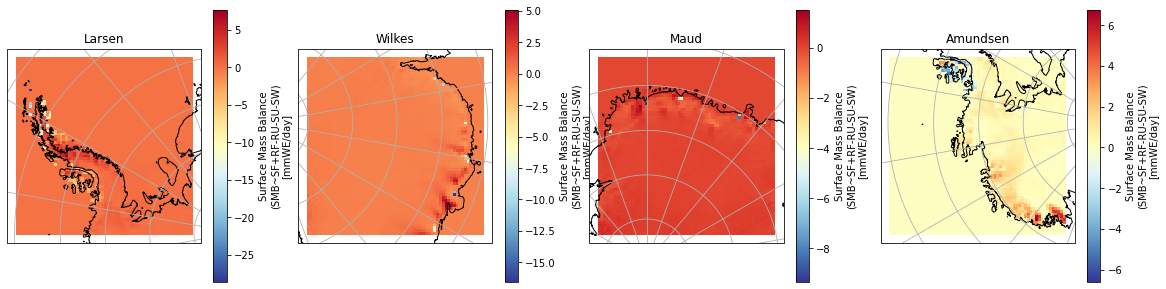

In [ ]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

In [ ]:
%%time
# Load datasets and U-Net
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    regions = REGIONS,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test
    **trainingParam
)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 580
Train set size: 5228

INFO: Train set size: 1045
Validation set size: 4183



<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          300
		Batch size:      32
		Learning rate:   0.005
		Training size:   4183
		Validation size: 1045
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/300: 100%|██████████| 4183/4183 [00:27<00:00, 150.21timestep/s, loss (batch)=0.668]
INFO: Checkpoint 1 saved!
Epoch 2/300:  60%|██████    | 2528/4183 [00:16<00:19, 85.42timestep/s, loss (batch)=0.871]

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 2/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.70timestep/s, loss (batch)=0.556]
INFO: Checkpoint 2 saved!
Epoch 3/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.11timestep/s, loss (batch)=1.22]
INFO: Checkpoint 3 saved!
Epoch 4/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.47timestep/s, loss (batch)=0.799]
INFO: Checkpoint 4 saved!
Epoch 5/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.41timestep/s, loss (batch)=0.8]
INFO: Checkpoint 5 saved!
Epoch 6/300: 100%|██████████| 4183/4183 [00:27<00:00, 151.84timestep/s, loss (batch)=0.819]
INFO: Checkpoint 6 saved!
Epoch 7/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.03timestep/s, loss (batch)=0.877]
INFO: Checkpoint 7 saved!
Epoch 8/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.44timestep/s, loss (batch)=1.07]
INFO: Checkpoint 8 saved!
Epoch 9/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.76timestep/s, loss (batch)=1.33]
INFO: Checkpoint 9 saved!
Epoch 10/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.70

Epoch 00115: reducing learning rate of group 0 to 5.0000e-05.


Epoch 12/300: 100%|██████████| 4183/4183 [00:27<00:00, 151.35timestep/s, loss (batch)=0.457]
INFO: Checkpoint 12 saved!
Epoch 13/300: 100%|██████████| 4183/4183 [00:28<00:00, 148.36timestep/s, loss (batch)=0.527]
INFO: Checkpoint 13 saved!
Epoch 14/300: 100%|██████████| 4183/4183 [00:26<00:00, 155.85timestep/s, loss (batch)=0.868]
INFO: Checkpoint 14 saved!
Epoch 15/300:  40%|███▉      | 1664/4183 [00:10<00:30, 81.90timestep/s, loss (batch)=0.602]

Epoch 00145: reducing learning rate of group 0 to 5.0000e-06.


Epoch 15/300:  90%|█████████ | 3776/4183 [00:24<00:04, 92.90timestep/s, loss (batch)=0.771]

Epoch 00150: reducing learning rate of group 0 to 5.0000e-07.


Epoch 15/300: 100%|██████████| 4183/4183 [00:26<00:00, 155.28timestep/s, loss (batch)=0.907]
INFO: Checkpoint 15 saved!
Epoch 16/300:  39%|███▉      | 1632/4183 [00:10<00:33, 75.74timestep/s, loss (batch)=0.56] 

Epoch 00155: reducing learning rate of group 0 to 5.0000e-08.


Epoch 16/300:  89%|████████▊ | 3712/4183 [00:24<00:06, 73.69timestep/s, loss (batch)=0.694]

Epoch 00160: reducing learning rate of group 0 to 5.0000e-09.


Epoch 16/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.11timestep/s, loss (batch)=0.762]
INFO: Checkpoint 16 saved!
Epoch 17/300: 100%|██████████| 4183/4183 [00:27<00:00, 154.75timestep/s, loss (batch)=0.642]
INFO: Checkpoint 17 saved!
Epoch 18/300: 100%|██████████| 4183/4183 [00:26<00:00, 154.99timestep/s, loss (batch)=0.526]
INFO: Checkpoint 18 saved!
Epoch 19/300: 100%|██████████| 4183/4183 [00:28<00:00, 148.60timestep/s, loss (batch)=0.814]
INFO: Checkpoint 19 saved!
Epoch 20/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.54timestep/s, loss (batch)=0.423]
INFO: Checkpoint 20 saved!
Epoch 21/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.90timestep/s, loss (batch)=0.777]
INFO: Checkpoint 21 saved!
Epoch 22/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.60timestep/s, loss (batch)=0.818]
INFO: Checkpoint 22 saved!
Epoch 23/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.74timestep/s, loss (batch)=0.706]
INFO: Checkpoint 23 saved!
Epoch 24/300: 100%|██████████| 4183/4183

RuntimeError: ignored

In [ ]:
# Load saved model
#today = str(date.today())
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = True,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

#today = '2022-05-05'
#today = date.today()
today = '2022-05-05'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    linkModel = 'https://drive.google.com/file/d/1rooLD6OJQX3YmJq-WqRm1ya6j8cLm48a/view?usp=sharing'
    idModel = '1rooLD6OJQX3YmJq-WqRm1ya6j8cLm48a'
    downloaded = drive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Comb, x_Comb, z_Comb, true_smb_Comb, r_Comb = predict(net, device, test_loader, model)

f = plt.figure(figsize=(20, 40))

# plot predictions
# plot predictions
plotRandomPredictions(
    preds_Comb,
    x_Comb,
    z_Comb,
    true_smb_Comb,
    r_Comb,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=REGIONS)
today = str(date.today())
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)